In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


- Clean notebook to be only new 
- Be able to merge train features and train targets
- same with test
- be able to then split and run program
- test for overfit
- create additional features (business/extra features from swing/ extra features from bugs)
- run reviews for NLP

In [2]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [3]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        #data = unicode(data, errors='replace')
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
#read_data_list
#fail_list
list_of_file_names_org = list_of_file_names

In [4]:
fail_list

[3]

In [5]:
for x in fail_list:
    del list_of_file_names[x]

In [6]:
list_of_file_names[23]

'./zip_2/Zip_MedianListingPricePerSqft_AllHomes.csv'

In [7]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [8]:
useful_df = build_useful_df(read_data_list_2)


In [9]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [10]:
len(sixteen_list)

30

In [11]:
good_columns = []
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)

In [12]:
sixteen_good = []
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [13]:
len(sixteen_good)

12

In [14]:
target_data = useful_df[23]

In [15]:
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [16]:
len(final_data_list[3])

10066

In [17]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
useful_df[0].head()

,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
RegionName,,,,
99654,11.142857,82.0,9.230769,7.260083
99645,7.589286,74.0,0.769231,7.260083
99577,8.108108,79.5,4.615385,7.260083
99567,9.836066,76.0,2.307692,7.260083
99518,14.925373,85.0,10.000000,7.260083


In [19]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    #features.dropna(inplace=True)
    
    #features = features.set_index(df.index)
    #print(features.iloc[1, :])
    return features
    
# List of data frames only on one now_time
def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    #now_time = pd.to_datetime(now_string)
    #now_value = df_for_target[now_string]
    #future_time = now_time + timedelta(days=6*31)
    #future_time_string= future_time.strftime("%Y-%m")
    #future_value = df_for_target[future_time_string]
            #target = future_value/now_value

    
    return df_one, target




test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
#extra_train_features_1, extra_train_targets_1 = make_modeling_data(final_data_list, target_data, '2016-06')
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)






#df = useful_df[num]
#columns = df.columns
#"2012", "2012", "2013",
date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            #if '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
                    #extra_train_features, extra_train_targets = make_modeling_data(df, new_time)
                    #train_features = train_features.append(extra_train_features)
                    #train_targets = train_targets.append(extra_train_targets)
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            #extra_train_features.dropna(inplace=True)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

In [20]:
train_targets.shape

(66132, 1)

In [21]:
train_features.shape

(66132, 120)

In [22]:
test_features.to_csv('test_features_to_merge_final.csv')

In [23]:
train_targets.head()

,target
RegionName,
99362,1.047544
99353,1.122185
99352,1.061993
99338,1.073945
99337,1.084956


#### Have not worked on w2v today; focused on business

In [24]:
w2v_features = pd.read_csv('real_business_w2v_features_3_6')

In [25]:
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)

In [26]:
w2v_features.shape

(959, 512)

In [27]:
w2v_features.index = w2v_features['postal_code']

In [28]:
w2v_features = w2v_features.iloc[:, 1:]

In [29]:
w2v_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min,...,490,491,492,493,494,495,496,497,498,499
postal_code,,,,,,,,,,,,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0,...,-0.007905,-0.050745,0.019509,0.089886,-0.067859,-0.057686,-0.073559,0.004500,-0.062522,0.054272
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0,...,0.024744,0.024881,0.039596,0.043280,-0.032233,-0.017144,0.060047,-0.002217,0.063483,-0.041164
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0,...,-0.032312,-0.024693,-0.019165,0.015924,-0.044335,-0.020998,0.041530,-0.048317,0.086379,-0.008370
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0,...,-0.014649,0.000344,0.033006,-0.015937,0.011044,0.094979,0.085854,-0.037768,-0.038649,0.033392
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0,...,-0.013431,0.007048,0.017738,-0.013003,0.016217,0.083113,0.092610,-0.032904,-0.048000,0.023717


#### Here is where business is imported

In [30]:
# Up to date business features where all rows are a singular zipcode
business_features = pd.read_csv('real_business_features_3_4')

In [31]:
len(business_features)

959

In [32]:
business_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 11 columns):
postal_code             959 non-null int64
is_open                 959 non-null float64
latitude                959 non-null float64
longitude               959 non-null float64
review_count            959 non-null float64
stars                   959 non-null float64
average_review_count    959 non-null float64
business_count          959 non-null float64
zip_review_count        959 non-null float64
average_review_max      959 non-null float64
average_review_min      959 non-null float64
dtypes: float64(10), int64(1)
memory usage: 82.5 KB


In [33]:
business_features.shape

(959, 11)

In [34]:
business_features['postal_code'] = business_features['postal_code'].astype(str)

In [35]:
business_features['postal_code'].nunique()

959

In [36]:
business_features = business_features.set_index('postal_code')

In [37]:
business_features.head()

,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
postal_code,,,,,,,,,,
2224,1.0,41.499208,-81.536689,7.000000,2.500000,7.000000,1.0,7.0,7.0,7.0
5440,1.0,44.964078,-73.285549,4.000000,4.250000,4.000000,2.0,8.0,5.0,3.0
5452,1.0,40.780821,-74.150722,49.000000,4.000000,49.000000,1.0,49.0,49.0,49.0
6618,1.0,51.083200,11.858200,8.000000,3.500000,8.000000,1.0,8.0,8.0,8.0
6632,1.0,51.213256,11.763245,5.888889,4.222222,5.888889,9.0,53.0,8.0,3.0


In [38]:
train_features.shape

(66132, 120)

In [39]:
train_features = train_features.reset_index()

In [40]:
test_features = test_features.reset_index()

In [398]:
len(test_features)

5511

In [41]:
train_targets = train_targets.reset_index()

In [42]:
test_targets = test_targets.reset_index()

In [43]:
business_features_index = business_features.index.unique()

In [44]:
region_name_list = train_features['RegionName'].unique()

In [403]:
shared_list = []
for zipc in business_features_index:
    if zipc in region_name_list:
        shared_list.append(zipc)

In [404]:
len(shared_list)

333

In [405]:
len(train_features)

55110

In [45]:
# Merging on index for train features and targets so it doesn't multiply 
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')

In [46]:
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')

In [47]:
len(train_merge)

66132

In [48]:
test_merge.head()

,RegionName_x,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,...,min_y,max_y,swing_y,change_y,swing_pos_y,swing_big_y,swing_neg_y,swing_loss_big_y,RegionName_y,target
0,99362,9.899305,2.694838,7.225547,15.562721,8.337174,-8.337174,0,0,1,...,0.874,0.894,0.020,0.018,0,0,1,0,99362,1.000168
1,99353,12.713502,4.201132,8.701869,20.788350,12.086481,6.728607,1,1,0,...,0.874,0.886,0.012,-0.010,0,0,1,0,99353,1.137133
2,99352,13.114296,2.222078,10.907130,17.667674,6.760545,2.172499,0,0,1,...,0.900,0.908,0.008,-0.004,0,0,1,0,99352,1.011334
3,99338,10.337470,2.859324,6.462035,15.113417,8.651382,-1.678754,1,0,0,...,0.884,0.896,0.012,0.008,0,0,1,0,99338,1.014762
4,99337,12.309892,3.922309,7.724349,18.444138,10.719789,-6.511823,1,0,0,...,0.878,0.890,0.012,0.012,0,0,1,0,99337,1.062254


In [49]:
train_merge = train_merge.set_index('RegionName_x')

In [50]:
test_merge = test_merge.set_index('RegionName_x')

In [51]:
train_merge.shape

(66132, 122)

In [52]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66132 entries, 99362 to 1001
Columns: 122 entries, mean_x to target
dtypes: float64(73), int64(48), object(1)
memory usage: 62.1+ MB


In [53]:
business_features.shape

(959, 10)

In [54]:
train_merge['RegionName_y'].nunique()

5511

In [55]:
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')

In [56]:
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [57]:
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [58]:
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [59]:
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [60]:
nztmc = new_zillow_test_merge.columns
test_merge = new_zillow_test_merge.iloc[:, :-10]

In [61]:
len(train_merge.columns)

122

In [62]:
len(test_merge.columns)

122

In [101]:
# This should have all instances of the train and test. 
business_train_merge.shape

(3330, 132)

In [103]:
w2v_train_merge.shape

(3330, 633)

In [303]:
# Is it ok that I have multiple of the aggregated information from Yelp?
business_train_merge.head(11)

,mean_x,std_x,min_x,max_x,swing_x,change_x,swing_pos_x,swing_big_x,swing_neg_x,swing_loss_big_x,...,is_open,latitude,longitude,review_count,stars,average_review_count,business_count,zip_review_count,average_review_max,average_review_min
15003,14.181132,2.147629,11.537536,18.258360,6.720823,-1.803249,0,0,1,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,15.011149,3.868854,8.586176,21.331859,12.745683,-3.823192,1,1,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,13.066543,2.749281,9.918464,18.321159,8.402695,-1.485973,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,14.267149,3.381999,9.615653,19.912455,10.296802,-3.850137,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,15.460086,3.876415,9.615653,20.093610,10.477957,8.783796,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.248923,2.768642,11.968512,21.010779,9.042267,2.144157,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.116125,4.855846,8.884885,24.155285,15.270400,2.256744,1,1,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,16.885622,3.206663,13.813915,24.155285,10.341370,-8.362070,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,13.163923,2.375110,9.706724,16.074128,6.367404,-2.375702,0,0,1,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0
15003,14.980037,2.924676,9.706724,19.470481,9.763757,8.018858,1,0,0,0,...,0.916667,40.598250,-80.223206,10.861111,3.958333,10.861111,36.0,391.0,50.0,3.0


In [63]:
train_merge = train_merge.drop('RegionName_y', 1)

In [64]:
test_merge = test_merge.drop('RegionName_y', 1)

### Most up to date Business attempt
- Why is y glitching with NaN?
- Update I have not removed any NaN's yet

In [65]:
train_merge.columns

Index(['mean_x', 'std_x', 'min_x', 'max_x', 'swing_x', 'change_x',
       'swing_pos_x', 'swing_big_x', 'swing_neg_x', 'swing_loss_big_x',
       ...
       'std_y', 'min_y', 'max_y', 'swing_y', 'change_y', 'swing_pos_y',
       'swing_big_y', 'swing_neg_y', 'swing_loss_big_y', 'target'],
      dtype='object', length=121)

In [66]:
train_merge.dropna(inplace=True)

In [67]:
test_merge.dropna(inplace=True)

In [194]:
train_merge.index.nunique()

5295

In [195]:
test_merge.index.nunique()

5439

In [68]:
business_train_merge.dropna(inplace=True)

In [69]:
business_test_merge.dropna(inplace=True)

In [70]:
w2v_train_merge.dropna(inplace=True)

In [71]:
w2v_test_merge.dropna(inplace=True)

In [72]:
w2v_train_merge.index.nunique()

326

In [73]:
w2v_test_merge.index.nunique()

331

In [207]:
w2v_train_index = w2v_train_merge.index

In [208]:
w2v_test_index = w2v_test_merge.index

In [317]:
bad_index = []
for index in w2v_test_index:
    if index not in w2v_train_index:
        bad_index.append(index)

In [321]:
bad_index

['85119', '44128', '29708', '15126', '15003']

In [320]:
w2v_test_merge = w2v_test_merge.drop(w2v_test_merge.index[bad_index])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [109]:
# 169 zipcodes in common after dropna. Had about double that before
business_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331 entries, 95966 to 15003
Columns: 132 entries, mean_x to average_review_min
dtypes: float64(83), int64(48), object(1)
memory usage: 343.9+ KB


In [114]:
col = w2v_test_merge.columns

In [127]:
col[120:130]

Index(['RegionName_y', 'target', 'is_open', 'latitude', 'longitude',
       'review_count', 'stars', 'average_review_count', 'business_count',
       'zip_review_count'],
      dtype='object')

In [74]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

In [75]:
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

In [76]:
# Setting up train and test
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

In [77]:
X_test_business.shape

(331, 130)

In [78]:
X_train_w2v.shape

(2839, 631)

In [79]:
X_test_w2v.shape

(331, 631)

In [80]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [81]:
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)

In [82]:
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)

In [83]:
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

In [84]:
y_test.var()

0.0028560998107322942

In [86]:
print(y_train.mean())
print(y_train.min())
print(y_train.max())

1.03161368584
0.720707555876
1.38819444444


In [87]:
def create_y_class(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    y_6 = []
    y_7 = []
    for y in y_list:
        if y <= .83:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .83 and y <= .90:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .90 and y <= .97:
            y_3.append(1)
        else:
            y_3.append(0)
        if y > .97 and y <= 1.05:
            y_4.append(1)
        else:
            y_4.append(0)
        if y > 1.05 and y <= 1.12:
            y_5.append(1)
        else:
            y_5.append(0)
        if y > 1.12 and y <= 1.19:
            y_6.append(1)
        else:
            y_6.append(0)
        if y > 1.19:
            y_7.append(1)
        else:
            y_7.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    y_df['6'] = y_6
    y_df['7'] = y_7
    return y_df

In [88]:
y_cat_train = create_y_class(y_train)

In [89]:
y_cat_test = create_y_class(y_test)

In [90]:
y_cat_train_w2v = create_y_class(y_train_w2v)

In [91]:
y_cat_test_w2v = create_y_class(y_test_w2v)

In [92]:
y_cat_train_business = create_y_class(y_train_business)

In [93]:
y_cat_test_business = create_y_class(y_test_business)

In [94]:
y_cat_train.head()

,1,2,3,4,5,6,7
0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [95]:
y_test_business.var()

0.0028560998107322942

In [62]:
# Hold overfit model for now
model = Sequential()
model.add(Dense(3000, input_shape=(110,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [106]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [107]:
model.fit(x=X_train, y=y_train, 
          batch_size=20000, 
          epochs=100, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 48053 samples, validate on 331 samples
Epoch 1/100
48053/48053 [==============================] - 2s 32us/step - loss: 3.8755 - val_loss: 0.3115
Epoch 2/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.2478 - val_loss: 0.0118
Epoch 3/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0674 - val_loss: 0.0587
Epoch 4/100
48053/48053 [==============================] - 1s 19us/step - loss: 0.0569 - val_loss: 0.0131
Epoch 5/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0576 - val_loss: 0.0826
Epoch 6/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0595 - val_loss: 0.0046
Epoch 7/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0593 - val_loss: 0.0761
Epoch 8/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0553 - val_loss: 0.0045
Epoch 9/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0575 - val_loss: 0.080

48053/48053 [==============================] - 1s 23us/step - loss: 0.0204 - val_loss: 0.0216
Epoch 78/100
48053/48053 [==============================] - 1s 20us/step - loss: 0.0188 - val_loss: 0.0080
Epoch 79/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0198 - val_loss: 0.0213
Epoch 80/100
48053/48053 [==============================] - 1s 22us/step - loss: 0.0206 - val_loss: 0.0230
Epoch 81/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0279 - val_loss: 0.0188
Epoch 82/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0149 - val_loss: 0.0050
Epoch 83/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0152 - val_loss: 0.0212
Epoch 84/100
48053/48053 [==============================] - 1s 22us/step - loss: 0.0187 - val_loss: 0.0140
Epoch 85/100
48053/48053 [==============================] - 1s 21us/step - loss: 0.0239 - val_loss: 0.0205
Epoch 86/100
48053/48053 [========================

In [ ]:
#loss = .00001441 (overfit) = .0038

#std = .072

In [108]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [109]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/2000
2839/2839 [==============================] - 1s 240us/step - loss: 517.4379 - val_loss: 0.4072
Epoch 2/2000
2839/2839 [==============================] - 0s 25us/step - loss: 0.4382 - val_loss: 0.0597
Epoch 3/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.1296 - val_loss: 0.0435
Epoch 4/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.1076 - val_loss: 0.0403
Epoch 5/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.1021 - val_loss: 0.0329
Epoch 6/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0951 - val_loss: 0.1765
Epoch 7/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.2153 - val_loss: 0.0480
Epoch 8/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0985 - val_loss: 0.0431
Epoch 9/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.1001 - val_loss: 0.0431
Epoch

2839/2839 [==============================] - 0s 31us/step - loss: 0.0253 - val_loss: 0.0172
Epoch 78/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0272 - val_loss: 0.0212
Epoch 79/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0327 - val_loss: 0.0286
Epoch 80/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0344 - val_loss: 0.0150
Epoch 81/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0273 - val_loss: 0.0306
Epoch 82/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.0319 - val_loss: 0.0036
Epoch 83/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0148 - val_loss: 0.0120
Epoch 84/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0201 - val_loss: 0.0081
Epoch 85/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0166 - val_loss: 0.0039
Epoch 86/2000
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 28us/step - loss: 0.1686 - val_loss: 0.0066
Epoch 154/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0173 - val_loss: 0.0026
Epoch 155/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.0129 - val_loss: 0.0028
Epoch 156/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0133 - val_loss: 0.0024
Epoch 157/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0118 - val_loss: 0.0024
Epoch 158/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0121 - val_loss: 0.0072
Epoch 159/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0244 - val_loss: 0.0058
Epoch 160/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0133 - val_loss: 0.0027
Epoch 161/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0094 - val_loss: 0.0024
Epoch 162/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0073 - val_loss: 0.0023
Epoch 230/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 231/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0067 - val_loss: 0.0046
Epoch 232/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.0090 - val_loss: 0.0029
Epoch 233/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0065 - val_loss: 0.0033
Epoch 234/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0073 - val_loss: 0.0027
Epoch 235/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0063 - val_loss: 0.0030
Epoch 236/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0068 - val_loss: 0.0030
Epoch 237/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.0066 - val_loss: 0.0032
Epoch 238/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 306/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 307/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0037
Epoch 308/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.0058 - val_loss: 0.0042
Epoch 309/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 310/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0039 - val_loss: 0.0033
Epoch 311/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 312/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0083 - val_loss: 0.0072
Epoch 313/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0123 - val_loss: 0.0202
Epoch 314/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 26us/step - loss: 0.0052 - val_loss: 0.0125
Epoch 382/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0040 - val_loss: 0.0107
Epoch 383/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0038 - val_loss: 0.0122
Epoch 384/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0125
Epoch 385/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0056 - val_loss: 0.0104
Epoch 386/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0043 - val_loss: 0.0100
Epoch 387/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0115
Epoch 388/2000
2839/2839 [==============================] - 0s 43us/step - loss: 0.0049 - val_loss: 0.0139
Epoch 389/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0058 - val_loss: 0.0104
Epoch 390/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 31us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 458/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 459/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0043 - val_loss: 0.0033
Epoch 460/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 461/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0043 - val_loss: 0.0024
Epoch 462/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 463/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0029 - val_loss: 0.0032
Epoch 464/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 465/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0049 - val_loss: 0.0031
Epoch 466/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 534/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0026 - val_loss: 0.0037
Epoch 535/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0036 - val_loss: 0.0050
Epoch 536/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0037 - val_loss: 0.0045
Epoch 537/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 538/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0031 - val_loss: 0.0036
Epoch 539/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0042
Epoch 540/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.0034 - val_loss: 0.0042
Epoch 541/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 542/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 28us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 610/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0028 - val_loss: 0.0049
Epoch 611/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0060
Epoch 612/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0027 - val_loss: 0.0049
Epoch 613/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.0029 - val_loss: 0.0049
Epoch 614/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 615/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0025 - val_loss: 0.0043
Epoch 616/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0029 - val_loss: 0.0051
Epoch 617/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0029 - val_loss: 0.0057
Epoch 618/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 28us/step - loss: 0.0045 - val_loss: 0.0077
Epoch 686/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0049 - val_loss: 0.0040
Epoch 687/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 688/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0019 - val_loss: 0.0042
Epoch 689/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0019 - val_loss: 0.0049
Epoch 690/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0059
Epoch 691/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0029 - val_loss: 0.0051
Epoch 692/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.0036 - val_loss: 0.0072
Epoch 693/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0058
Epoch 694/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0054 - val_loss: 0.0049
Epoch 762/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0060 - val_loss: 0.0063
Epoch 763/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0076 - val_loss: 0.0053
Epoch 764/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0068 - val_loss: 0.0047
Epoch 765/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0064 - val_loss: 0.0056
Epoch 766/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0080 - val_loss: 0.0129
Epoch 767/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0255 - val_loss: 0.3140
Epoch 768/2000
2839/2839 [==============================] - 0s 27us/step - loss: 1.5194 - val_loss: 0.4700
Epoch 769/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.4250 - val_loss: 0.0244
Epoch 770/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0019 - val_loss: 0.0050
Epoch 838/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0054
Epoch 839/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0018 - val_loss: 0.0055
Epoch 840/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0021 - val_loss: 0.0048
Epoch 841/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0045
Epoch 842/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0054
Epoch 843/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 844/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0047
Epoch 845/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0043
Epoch 846/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0398 - val_loss: 0.0829
Epoch 914/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.0814 - val_loss: 0.0030
Epoch 915/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 916/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 917/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 918/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 919/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0051 - val_loss: 0.0089
Epoch 920/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.0236 - val_loss: 0.4965
Epoch 921/2000
2839/2839 [==============================] - 0s 26us/step - loss: 3.1200 - val_loss: 0.6207
Epoch 922/2000
2839/2839 [==========================

2839/2839 [==============================] - 0s 29us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 990/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0024 - val_loss: 0.0029
Epoch 991/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 992/2000
2839/2839 [==============================] - 0s 42us/step - loss: 0.0023 - val_loss: 0.0030
Epoch 993/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 994/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 995/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0033
Epoch 996/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.0022 - val_loss: 0.0039
Epoch 997/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0055
Epoch 998/2000
2839/2839 [==========================

Epoch 1065/2000
2839/2839 [==============================] - 0s 28us/step - loss: 1.3951 - val_loss: 0.0328
Epoch 1066/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.2355 - val_loss: 0.0060
Epoch 1067/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.2045 - val_loss: 0.0052
Epoch 1068/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.1867 - val_loss: 0.0044
Epoch 1069/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.1985 - val_loss: 0.0054
Epoch 1070/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.1846 - val_loss: 0.0068
Epoch 1071/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.1755 - val_loss: 0.0162
Epoch 1072/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.1760 - val_loss: 0.1337
Epoch 1073/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.4166 - val_loss: 3.2534
Epoch 1074/2000
2839/2839 [=

2839/2839 [==============================] - 0s 27us/step - loss: 17.9269 - val_loss: 0.6417
Epoch 1140/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.8091 - val_loss: 0.0758
Epoch 1141/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3590 - val_loss: 0.0384
Epoch 1142/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.3030 - val_loss: 0.0404
Epoch 1143/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.3177 - val_loss: 0.0731
Epoch 1144/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.3529 - val_loss: 0.3211
Epoch 1145/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.6965 - val_loss: 2.1523
Epoch 1146/2000
2839/2839 [==============================] - 0s 29us/step - loss: 3.8810 - val_loss: 31.9681
Epoch 1147/2000
2839/2839 [==============================] - 0s 27us/step - loss: 65.7122 - val_loss: 858.8224
Epoch 1148/2000
2839/2839 [============

2839/2839 [==============================] - 0s 30us/step - loss: 10838.1766 - val_loss: 34832.2539
Epoch 1214/2000
2839/2839 [==============================] - 0s 29us/step - loss: 41996.7170 - val_loss: 98880.1484
Epoch 1215/2000
2839/2839 [==============================] - 0s 30us/step - loss: 87741.5387 - val_loss: 28977.8066
Epoch 1216/2000
2839/2839 [==============================] - 0s 29us/step - loss: 20057.1303 - val_loss: 660.0502
Epoch 1217/2000
2839/2839 [==============================] - 0s 28us/step - loss: 475.4667 - val_loss: 59.3737
Epoch 1218/2000
2839/2839 [==============================] - 0s 28us/step - loss: 46.7601 - val_loss: 14.7182
Epoch 1219/2000
2839/2839 [==============================] - 0s 28us/step - loss: 12.7410 - val_loss: 10.5943
Epoch 1220/2000
2839/2839 [==============================] - 0s 28us/step - loss: 10.4612 - val_loss: 16.8651
Epoch 1221/2000
2839/2839 [==============================] - 0s 28us/step - loss: 19.4055 - val_loss: 61.4586
Epo

2839/2839 [==============================] - 0s 29us/step - loss: 385043.8221 - val_loss: 396643.2812
Epoch 1286/2000
2839/2839 [==============================] - 0s 28us/step - loss: 285051.1087 - val_loss: 48944.5469
Epoch 1287/2000
2839/2839 [==============================] - 0s 29us/step - loss: 39665.1856 - val_loss: 17901.2051
Epoch 1288/2000
2839/2839 [==============================] - 0s 31us/step - loss: 15463.5333 - val_loss: 13240.1270
Epoch 1289/2000
2839/2839 [==============================] - 0s 29us/step - loss: 12414.1080 - val_loss: 18915.0664
Epoch 1290/2000
2839/2839 [==============================] - 0s 30us/step - loss: 20248.5577 - val_loss: 53170.8164
Epoch 1291/2000
2839/2839 [==============================] - 0s 29us/step - loss: 58090.8905 - val_loss: 121721.4141
Epoch 1292/2000
2839/2839 [==============================] - 0s 28us/step - loss: 119343.5573 - val_loss: 181073.5781
Epoch 1293/2000
2839/2839 [==============================] - 0s 29us/step - loss: 

Epoch 1357/2000
2839/2839 [==============================] - 0s 29us/step - loss: 13989.2515 - val_loss: 93190.4844
Epoch 1358/2000
2839/2839 [==============================] - 0s 29us/step - loss: 111826.4714 - val_loss: 220361.1406
Epoch 1359/2000
2839/2839 [==============================] - 0s 29us/step - loss: 159648.8781 - val_loss: 37318.2969
Epoch 1360/2000
2839/2839 [==============================] - 0s 29us/step - loss: 32396.1576 - val_loss: 22928.9980
Epoch 1361/2000
2839/2839 [==============================] - 0s 28us/step - loss: 20134.9555 - val_loss: 21589.6094
Epoch 1362/2000
2839/2839 [==============================] - 0s 29us/step - loss: 22069.4296 - val_loss: 45851.4453
Epoch 1363/2000
2839/2839 [==============================] - 0s 27us/step - loss: 51193.2201 - val_loss: 125169.9453
Epoch 1364/2000
2839/2839 [==============================] - 0s 28us/step - loss: 111224.4512 - val_loss: 95039.4141
Epoch 1365/2000
2839/2839 [==============================] - 0s 29u

2839/2839 [==============================] - 0s 27us/step - loss: 5702.8176 - val_loss: 608.8180
Epoch 1429/2000
2839/2839 [==============================] - 0s 28us/step - loss: 456.1961 - val_loss: 128.4641
Epoch 1430/2000
2839/2839 [==============================] - 0s 31us/step - loss: 105.8967 - val_loss: 71.6996
Epoch 1431/2000
2839/2839 [==============================] - 0s 27us/step - loss: 66.2304 - val_loss: 89.6905
Epoch 1432/2000
2839/2839 [==============================] - 0s 29us/step - loss: 96.4375 - val_loss: 265.6183
Epoch 1433/2000
2839/2839 [==============================] - 0s 29us/step - loss: 337.3096 - val_loss: 1579.7456
Epoch 1434/2000
2839/2839 [==============================] - 0s 27us/step - loss: 2350.5906 - val_loss: 17194.9297
Epoch 1435/2000
2839/2839 [==============================] - 0s 27us/step - loss: 29522.1391 - val_loss: 196520.9844
Epoch 1436/2000
2839/2839 [==============================] - 0s 28us/step - loss: 185739.5818 - val_loss: 82945.71

2839/2839 [==============================] - 0s 30us/step - loss: 467841.4746 - val_loss: 312464.2500
Epoch 1499/2000
2839/2839 [==============================] - 0s 28us/step - loss: 280722.1068 - val_loss: 307886.2500
Epoch 1500/2000
2839/2839 [==============================] - 0s 29us/step - loss: 274582.0018 - val_loss: 248851.4844
Epoch 1501/2000
2839/2839 [==============================] - 0s 28us/step - loss: 207153.1708 - val_loss: 119102.2500
Epoch 1502/2000
2839/2839 [==============================] - 0s 30us/step - loss: 99068.2030 - val_loss: 80599.1875
Epoch 1503/2000
2839/2839 [==============================] - 0s 30us/step - loss: 74451.7740 - val_loss: 117183.5312
Epoch 1504/2000
2839/2839 [==============================] - 0s 30us/step - loss: 120642.4654 - val_loss: 264689.5312
Epoch 1505/2000
2839/2839 [==============================] - 0s 29us/step - loss: 255884.8580 - val_loss: 295367.0938
Epoch 1506/2000
2839/2839 [==============================] - 0s 29us/step -

Epoch 1568/2000
2839/2839 [==============================] - 0s 27us/step - loss: 138416.1180 - val_loss: 312937.0625
Epoch 1569/2000
2839/2839 [==============================] - 0s 28us/step - loss: 304076.7223 - val_loss: 343456.7188
Epoch 1570/2000
2839/2839 [==============================] - 0s 28us/step - loss: 279196.0165 - val_loss: 157218.7500
Epoch 1571/2000
2839/2839 [==============================] - 0s 27us/step - loss: 127338.8026 - val_loss: 70242.2812
Epoch 1572/2000
2839/2839 [==============================] - 0s 28us/step - loss: 59086.4591 - val_loss: 41133.4727
Epoch 1573/2000
2839/2839 [==============================] - 0s 27us/step - loss: 35852.3019 - val_loss: 36279.4922
Epoch 1574/2000
2839/2839 [==============================] - 0s 28us/step - loss: 34347.9376 - val_loss: 51894.5664
Epoch 1575/2000
2839/2839 [==============================] - 0s 28us/step - loss: 53552.7410 - val_loss: 101893.8359
Epoch 1576/2000
2839/2839 [==============================] - 0s 

2839/2839 [==============================] - 0s 29us/step - loss: 7218.2597 - val_loss: 5081.5615
Epoch 1639/2000
2839/2839 [==============================] - 0s 29us/step - loss: 4643.1553 - val_loss: 6747.0093
Epoch 1640/2000
2839/2839 [==============================] - 0s 28us/step - loss: 7057.6133 - val_loss: 18422.4551
Epoch 1641/2000
2839/2839 [==============================] - 0s 31us/step - loss: 22621.8542 - val_loss: 92227.3594
Epoch 1642/2000
2839/2839 [==============================] - 0s 30us/step - loss: 119939.4171 - val_loss: 603346.7500
Epoch 1643/2000
2839/2839 [==============================] - 0s 30us/step - loss: 659654.2992 - val_loss: 472401.7812
Epoch 1644/2000
2839/2839 [==============================] - 0s 29us/step - loss: 328475.1488 - val_loss: 16273.9648
Epoch 1645/2000
2839/2839 [==============================] - 0s 30us/step - loss: 11352.4741 - val_loss: 1183.1837
Epoch 1646/2000
2839/2839 [==============================] - 0s 31us/step - loss: 889.655

2839/2839 [==============================] - 0s 29us/step - loss: 4781.0788 - val_loss: 2086.8955
Epoch 1709/2000
2839/2839 [==============================] - 0s 29us/step - loss: 1824.4004 - val_loss: 1945.1233
Epoch 1710/2000
2839/2839 [==============================] - 0s 28us/step - loss: 1911.9069 - val_loss: 3895.5774
Epoch 1711/2000
2839/2839 [==============================] - 0s 28us/step - loss: 4454.1754 - val_loss: 15399.7129
Epoch 1712/2000
2839/2839 [==============================] - 0s 29us/step - loss: 20449.6681 - val_loss: 109474.8438
Epoch 1713/2000
2839/2839 [==============================] - 0s 27us/step - loss: 165231.2149 - val_loss: 841021.8750
Epoch 1714/2000
2839/2839 [==============================] - 0s 37us/step - loss: 840881.8376 - val_loss: 845461.4375
Epoch 1715/2000
2839/2839 [==============================] - 0s 38us/step - loss: 664795.4306 - val_loss: 143768.4375
Epoch 1716/2000
2839/2839 [==============================] - 0s 27us/step - loss: 102838

2839/2839 [==============================] - 0s 31us/step - loss: 91217.1714 - val_loss: 161096.0156
Epoch 1779/2000
2839/2839 [==============================] - 0s 31us/step - loss: 172585.3071 - val_loss: 460244.8438
Epoch 1780/2000
2839/2839 [==============================] - 0s 31us/step - loss: 480516.9372 - val_loss: 1012710.3750
Epoch 1781/2000
2839/2839 [==============================] - 0s 29us/step - loss: 917000.7231 - val_loss: 965269.8750
Epoch 1782/2000
2839/2839 [==============================] - 0s 28us/step - loss: 785914.6206 - val_loss: 245248.8281
Epoch 1783/2000
2839/2839 [==============================] - 0s 28us/step - loss: 186381.0155 - val_loss: 58215.2617
Epoch 1784/2000
2839/2839 [==============================] - 0s 28us/step - loss: 46947.4371 - val_loss: 29352.1895
Epoch 1785/2000
2839/2839 [==============================] - 0s 28us/step - loss: 26198.1668 - val_loss: 33681.3945
Epoch 1786/2000
2839/2839 [==============================] - 0s 28us/step - l

2839/2839 [==============================] - 0s 30us/step - loss: 250.7058 - val_loss: 421.4428
Epoch 1849/2000
2839/2839 [==============================] - 0s 30us/step - loss: 453.0996 - val_loss: 1361.3230
Epoch 1850/2000
2839/2839 [==============================] - 0s 30us/step - loss: 1735.9471 - val_loss: 8389.6836
Epoch 1851/2000
2839/2839 [==============================] - 0s 31us/step - loss: 12284.3288 - val_loss: 78697.3203
Epoch 1852/2000
2839/2839 [==============================] - 0s 29us/step - loss: 100749.3478 - val_loss: 205818.9531
Epoch 1853/2000
2839/2839 [==============================] - 0s 29us/step - loss: 157630.6743 - val_loss: 20853.9043
Epoch 1854/2000
2839/2839 [==============================] - 0s 27us/step - loss: 14895.3997 - val_loss: 1262.7952
Epoch 1855/2000
2839/2839 [==============================] - 0s 28us/step - loss: 937.8397 - val_loss: 211.0750
Epoch 1856/2000
2839/2839 [==============================] - 0s 28us/step - loss: 172.3996 - val_lo

2839/2839 [==============================] - 0s 29us/step - loss: 3483.2639 - val_loss: 16598.6562
Epoch 1921/2000
2839/2839 [==============================] - 0s 28us/step - loss: 21446.2040 - val_loss: 61585.8008
Epoch 1922/2000
2839/2839 [==============================] - 0s 30us/step - loss: 55974.8102 - val_loss: 55046.5781
Epoch 1923/2000
2839/2839 [==============================] - 0s 29us/step - loss: 43916.4649 - val_loss: 21229.2168
Epoch 1924/2000
2839/2839 [==============================] - 0s 28us/step - loss: 17506.0012 - val_loss: 10092.2480
Epoch 1925/2000
2839/2839 [==============================] - 0s 29us/step - loss: 8877.4631 - val_loss: 8066.4336
Epoch 1926/2000
2839/2839 [==============================] - 0s 28us/step - loss: 7461.9806 - val_loss: 9280.7383
Epoch 1927/2000
2839/2839 [==============================] - 0s 28us/step - loss: 9541.2305 - val_loss: 15959.7080
Epoch 1928/2000
2839/2839 [==============================] - 0s 28us/step - loss: 15563.1999 -

2839/2839 [==============================] - 0s 29us/step - loss: 0.6513 - val_loss: 1.7960
Epoch 1994/2000
2839/2839 [==============================] - 0s 28us/step - loss: 2.4274 - val_loss: 11.7206
Epoch 1995/2000
2839/2839 [==============================] - 0s 29us/step - loss: 17.8679 - val_loss: 144.4870
Epoch 1996/2000
2839/2839 [==============================] - 0s 30us/step - loss: 276.7764 - val_loss: 3545.9214
Epoch 1997/2000
2839/2839 [==============================] - 0s 30us/step - loss: 8077.4334 - val_loss: 73729.8203
Epoch 1998/2000
2839/2839 [==============================] - 0s 29us/step - loss: 60629.5427 - val_loss: 6304.0103
Epoch 1999/2000
2839/2839 [==============================] - 0s 29us/step - loss: 4237.4125 - val_loss: 37.3660
Epoch 2000/2000
2839/2839 [==============================] - 0s 28us/step - loss: 26.4349 - val_loss: 1.1857


In [110]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [112]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 2/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 3/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 6/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 7/500
2839/2839 [==============================] - 0s 69us/step - loss: 0.0020 - val_loss: 0.0029
Epoch 8/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 10/500
2839

2839/2839 [==============================] - 0s 64us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 79/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 80/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 81/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 82/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 83/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 84/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 85/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 86/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 87/500
2839/2839 [==============================] - 0s 59us/st

2839/2839 [==============================] - 0s 81us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 156/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 157/500
2839/2839 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 158/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.0017 - val_loss: 0.0025
Epoch 159/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 160/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 161/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 162/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 163/500
2839/2839 [==============================] - 0s 81us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 77us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 233/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 234/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 235/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 236/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 237/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 238/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 239/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 240/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 241/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 79us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 310/500
2839/2839 [==============================] - 0s 70us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 311/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 312/500
2839/2839 [==============================] - 0s 82us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 313/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 314/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 315/500
2839/2839 [==============================] - 0s 69us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 316/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 317/500
2839/2839 [==============================] - 0s 80us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 78us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 387/500
2839/2839 [==============================] - 0s 71us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 388/500
2839/2839 [==============================] - 0s 84us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 389/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 390/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 391/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0014 - val_loss: 0.0024
Epoch 392/500
2839/2839 [==============================] - 0s 61us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 393/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 394/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 395/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 82us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 464/500
2839/2839 [==============================] - 0s 83us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 465/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 466/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0013 - val_loss: 0.0023
Epoch 467/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0015 - val_loss: 0.0022
Epoch 468/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 469/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 470/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 471/500
2839/2839 [==============================] - 0s 76us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 472/500
2839/2839 [==============================] - 0

In [113]:
class_weight = {0 : 2,
    1: 1.25,
    2: .75,
    3: .25,
    4: .75,
    5: 1.25,
    6: 2}

In [114]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [115]:
zillow_model = model.fit(x=X_train, y=y_cat_train, 
          batch_size=20000, 
          epochs=200, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)

Train on 48053 samples, validate on 331 samples
Epoch 1/200
48053/48053 [==============================] - 2s 43us/step - loss: 1.0318 - acc: 0.1666 - val_loss: 1.9884 - val_acc: 0.0544
Epoch 2/200
48053/48053 [==============================] - 1s 21us/step - loss: 1.0297 - acc: 0.1738 - val_loss: 1.9837 - val_acc: 0.0574
Epoch 3/200
48053/48053 [==============================] - 1s 21us/step - loss: 1.0282 - acc: 0.1788 - val_loss: 1.9798 - val_acc: 0.0604
Epoch 4/200
48053/48053 [==============================] - 1s 21us/step - loss: 1.0269 - acc: 0.1840 - val_loss: 1.9763 - val_acc: 0.0634
Epoch 5/200
48053/48053 [==============================] - 1s 21us/step - loss: 1.0257 - acc: 0.1894 - val_loss: 1.9731 - val_acc: 0.0725
Epoch 6/200
48053/48053 [==============================] - 1s 22us/step - loss: 1.0249 - acc: 0.1921 - val_loss: 1.9698 - val_acc: 0.0755
Epoch 7/200
48053/48053 [==============================] - 1s 23us/step - loss: 1.0234 - acc: 0.1964 - val_loss: 1.9668 - va

48053/48053 [==============================] - 1s 24us/step - loss: 0.9858 - acc: 0.3341 - val_loss: 1.8509 - val_acc: 0.3384
Epoch 60/200
48053/48053 [==============================] - 1s 23us/step - loss: 0.9854 - acc: 0.3341 - val_loss: 1.8490 - val_acc: 0.3444
Epoch 61/200
48053/48053 [==============================] - 1s 23us/step - loss: 0.9847 - acc: 0.3396 - val_loss: 1.8471 - val_acc: 0.3444
Epoch 62/200
48053/48053 [==============================] - 1s 25us/step - loss: 0.9837 - acc: 0.3446 - val_loss: 1.8452 - val_acc: 0.3474
Epoch 63/200
48053/48053 [==============================] - 1s 22us/step - loss: 0.9837 - acc: 0.3428 - val_loss: 1.8432 - val_acc: 0.3505
Epoch 64/200
48053/48053 [==============================] - 1s 23us/step - loss: 0.9830 - acc: 0.3436 - val_loss: 1.8415 - val_acc: 0.3535
Epoch 65/200
48053/48053 [==============================] - 1s 24us/step - loss: 0.9823 - acc: 0.3467 - val_loss: 1.8396 - val_acc: 0.3565
Epoch 66/200
48053/48053 [==============

Epoch 118/200
48053/48053 [==============================] - 1s 25us/step - loss: 0.9522 - acc: 0.4511 - val_loss: 1.7475 - val_acc: 0.5136
Epoch 119/200
48053/48053 [==============================] - 1s 25us/step - loss: 0.9517 - acc: 0.4538 - val_loss: 1.7459 - val_acc: 0.5106
Epoch 120/200
48053/48053 [==============================] - 1s 27us/step - loss: 0.9508 - acc: 0.4539 - val_loss: 1.7445 - val_acc: 0.5106
Epoch 121/200
48053/48053 [==============================] - 1s 26us/step - loss: 0.9503 - acc: 0.4549 - val_loss: 1.7430 - val_acc: 0.5106
Epoch 122/200
48053/48053 [==============================] - 1s 28us/step - loss: 0.9497 - acc: 0.4550 - val_loss: 1.7414 - val_acc: 0.5106
Epoch 123/200
48053/48053 [==============================] - 1s 24us/step - loss: 0.9487 - acc: 0.4569 - val_loss: 1.7398 - val_acc: 0.5106
Epoch 124/200
48053/48053 [==============================] - 1s 25us/step - loss: 0.9485 - acc: 0.4554 - val_loss: 1.7383 - val_acc: 0.5076
Epoch 125/200
48053/

48053/48053 [==============================] - 1s 21us/step - loss: 0.9134 - acc: 0.4517 - val_loss: 1.6607 - val_acc: 0.4532
Epoch 177/200
48053/48053 [==============================] - 1s 26us/step - loss: 0.9135 - acc: 0.4510 - val_loss: 1.6594 - val_acc: 0.4532
Epoch 178/200
48053/48053 [==============================] - 1s 28us/step - loss: 0.9123 - acc: 0.4452 - val_loss: 1.6579 - val_acc: 0.4471
Epoch 179/200
48053/48053 [==============================] - 1s 27us/step - loss: 0.9116 - acc: 0.4469 - val_loss: 1.6563 - val_acc: 0.4502
Epoch 180/200
48053/48053 [==============================] - 1s 27us/step - loss: 0.9112 - acc: 0.4426 - val_loss: 1.6549 - val_acc: 0.4441
Epoch 181/200
48053/48053 [==============================] - 1s 23us/step - loss: 0.9107 - acc: 0.4437 - val_loss: 1.6536 - val_acc: 0.4471
Epoch 182/200
48053/48053 [==============================] - 1s 23us/step - loss: 0.9097 - acc: 0.4428 - val_loss: 1.6522 - val_acc: 0.4532
Epoch 183/200
48053/48053 [=======

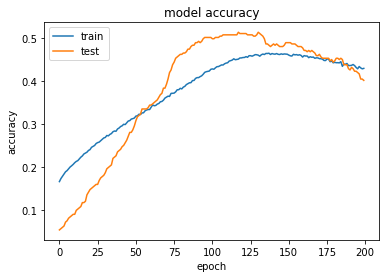

In [116]:
plt.plot(zillow_model.history['acc'])
plt.plot(zillow_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [117]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.00001)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
business_model = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/2000
2839/2839 [==============================] - 1s 336us/step - loss: 1.1725 - acc: 0.0831 - val_loss: 2.3861 - val_acc: 0.1571
Epoch 2/2000
2839/2839 [==============================] - 0s 34us/step - loss: 1.1728 - acc: 0.0821 - val_loss: 2.3715 - val_acc: 0.1571
Epoch 3/2000
2839/2839 [==============================] - 0s 33us/step - loss: 1.1651 - acc: 0.0821 - val_loss: 2.3594 - val_acc: 0.1571
Epoch 4/2000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1589 - acc: 0.0821 - val_loss: 2.3484 - val_acc: 0.1571
Epoch 5/2000
2839/2839 [==============================] - 0s 30us/step - loss: 1.1472 - acc: 0.0835 - val_loss: 2.3386 - val_acc: 0.1571
Epoch 6/2000
2839/2839 [==============================] - 0s 31us/step - loss: 1.1496 - acc: 0.0824 - val_loss: 2.3288 - val_acc: 0.1571
Epoch 7/2000
2839/2839 [==============================] - 0s 32us/step - loss: 1.1423 - acc: 0.0821 - val_loss: 2.3197 - val_acc: 

Epoch 60/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.9923 - acc: 0.1363 - val_loss: 1.9583 - val_acc: 0.1420
Epoch 61/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.9856 - acc: 0.1360 - val_loss: 1.9529 - val_acc: 0.1480
Epoch 62/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9879 - acc: 0.1437 - val_loss: 1.9473 - val_acc: 0.1480
Epoch 63/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.9836 - acc: 0.1427 - val_loss: 1.9421 - val_acc: 0.1480
Epoch 64/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.9799 - acc: 0.1529 - val_loss: 1.9361 - val_acc: 0.1480
Epoch 65/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.9792 - acc: 0.1448 - val_loss: 1.9300 - val_acc: 0.1541
Epoch 66/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.9751 - acc: 0.1504 - val_loss: 1.9250 - val_acc: 0.1571
Epoch 67/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 32us/step - loss: 0.8808 - acc: 0.2691 - val_loss: 1.6739 - val_acc: 0.2205
Epoch 120/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8748 - acc: 0.2698 - val_loss: 1.6693 - val_acc: 0.2205
Epoch 121/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.8733 - acc: 0.2783 - val_loss: 1.6653 - val_acc: 0.2205
Epoch 122/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8788 - acc: 0.2723 - val_loss: 1.6623 - val_acc: 0.2205
Epoch 123/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.8722 - acc: 0.2800 - val_loss: 1.6593 - val_acc: 0.2205
Epoch 124/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.8745 - acc: 0.2758 - val_loss: 1.6553 - val_acc: 0.2205
Epoch 125/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.8681 - acc: 0.2804 - val_loss: 1.6518 - val_acc: 0.2205
Epoch 126/2000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.8230 - acc: 0.2955 - val_loss: 1.4908 - val_acc: 0.2205
Epoch 179/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8188 - acc: 0.3005 - val_loss: 1.4878 - val_acc: 0.2205
Epoch 180/2000
2839/2839 [==============================] - 0s 36us/step - loss: 0.8197 - acc: 0.3015 - val_loss: 1.4859 - val_acc: 0.2205
Epoch 181/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8153 - acc: 0.2938 - val_loss: 1.4833 - val_acc: 0.2205
Epoch 182/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.8179 - acc: 0.3015 - val_loss: 1.4815 - val_acc: 0.2205
Epoch 183/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.8168 - acc: 0.3012 - val_loss: 1.4788 - val_acc: 0.2205
Epoch 184/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.8179 - acc: 0.3033 - val_loss: 1.4756 - val_acc: 0.2205
Epoch 185/2000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.7980 - acc: 0.3114 - val_loss: 1.3989 - val_acc: 0.2205
Epoch 238/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7996 - acc: 0.3103 - val_loss: 1.3980 - val_acc: 0.2205
Epoch 239/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.8017 - acc: 0.3114 - val_loss: 1.3972 - val_acc: 0.2205
Epoch 240/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7917 - acc: 0.3131 - val_loss: 1.3958 - val_acc: 0.2205
Epoch 241/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7985 - acc: 0.3110 - val_loss: 1.3950 - val_acc: 0.2205
Epoch 242/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7952 - acc: 0.3198 - val_loss: 1.3947 - val_acc: 0.2205
Epoch 243/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7970 - acc: 0.3128 - val_loss: 1.3937 - val_acc: 0.2205
Epoch 244/2000
2839/2839 [================

2839/2839 [==============================] - 0s 31us/step - loss: 0.7892 - acc: 0.3107 - val_loss: 1.3778 - val_acc: 0.2205
Epoch 297/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7943 - acc: 0.3188 - val_loss: 1.3789 - val_acc: 0.2205
Epoch 298/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7907 - acc: 0.3174 - val_loss: 1.3788 - val_acc: 0.2236
Epoch 299/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7904 - acc: 0.3198 - val_loss: 1.3789 - val_acc: 0.2205
Epoch 300/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7905 - acc: 0.3142 - val_loss: 1.3801 - val_acc: 0.2236
Epoch 301/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7898 - acc: 0.3226 - val_loss: 1.3816 - val_acc: 0.2236
Epoch 302/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7841 - acc: 0.3209 - val_loss: 1.3811 - val_acc: 0.2236
Epoch 303/2000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.7860 - acc: 0.3230 - val_loss: 1.3777 - val_acc: 0.2205
Epoch 356/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7828 - acc: 0.3318 - val_loss: 1.3773 - val_acc: 0.2205
Epoch 357/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7828 - acc: 0.3237 - val_loss: 1.3782 - val_acc: 0.2205
Epoch 358/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7840 - acc: 0.3174 - val_loss: 1.3798 - val_acc: 0.2205
Epoch 359/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7879 - acc: 0.3234 - val_loss: 1.3778 - val_acc: 0.2205
Epoch 360/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7866 - acc: 0.3188 - val_loss: 1.3778 - val_acc: 0.2205
Epoch 361/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7787 - acc: 0.3283 - val_loss: 1.3763 - val_acc: 0.2205
Epoch 362/2000
2839/2839 [================

Epoch 414/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7772 - acc: 0.3283 - val_loss: 1.3753 - val_acc: 0.2266
Epoch 415/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7763 - acc: 0.3191 - val_loss: 1.3748 - val_acc: 0.2266
Epoch 416/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7820 - acc: 0.3241 - val_loss: 1.3767 - val_acc: 0.2266
Epoch 417/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7813 - acc: 0.3219 - val_loss: 1.3754 - val_acc: 0.2266
Epoch 418/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7775 - acc: 0.3160 - val_loss: 1.3739 - val_acc: 0.2266
Epoch 419/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7855 - acc: 0.3195 - val_loss: 1.3734 - val_acc: 0.2266
Epoch 420/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7804 - acc: 0.3265 - val_loss: 1.3722 - val_acc: 0.2266
Epoch 421/2000
2839/2839 [=

Epoch 473/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7704 - acc: 0.3311 - val_loss: 1.3637 - val_acc: 0.2538
Epoch 474/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7771 - acc: 0.3315 - val_loss: 1.3645 - val_acc: 0.2538
Epoch 475/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7717 - acc: 0.3360 - val_loss: 1.3654 - val_acc: 0.2477
Epoch 476/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7762 - acc: 0.3322 - val_loss: 1.3673 - val_acc: 0.2477
Epoch 477/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7753 - acc: 0.3300 - val_loss: 1.3672 - val_acc: 0.2477
Epoch 478/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7739 - acc: 0.3318 - val_loss: 1.3672 - val_acc: 0.2477
Epoch 479/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7775 - acc: 0.3308 - val_loss: 1.3682 - val_acc: 0.2477
Epoch 480/2000
2839/2839 [=

Epoch 532/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7681 - acc: 0.3353 - val_loss: 1.3570 - val_acc: 0.2538
Epoch 533/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7712 - acc: 0.3353 - val_loss: 1.3572 - val_acc: 0.2538
Epoch 534/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7690 - acc: 0.3371 - val_loss: 1.3557 - val_acc: 0.2538
Epoch 535/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7625 - acc: 0.3322 - val_loss: 1.3558 - val_acc: 0.2538
Epoch 536/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7664 - acc: 0.3438 - val_loss: 1.3551 - val_acc: 0.2538
Epoch 537/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7670 - acc: 0.3399 - val_loss: 1.3543 - val_acc: 0.2538
Epoch 538/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7703 - acc: 0.3406 - val_loss: 1.3537 - val_acc: 0.2538
Epoch 539/2000
2839/2839 [=

2839/2839 [==============================] - 0s 32us/step - loss: 0.7610 - acc: 0.3519 - val_loss: 1.3515 - val_acc: 0.2598
Epoch 591/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7676 - acc: 0.3350 - val_loss: 1.3532 - val_acc: 0.2568
Epoch 592/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7631 - acc: 0.3336 - val_loss: 1.3527 - val_acc: 0.2598
Epoch 593/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7666 - acc: 0.3364 - val_loss: 1.3514 - val_acc: 0.2628
Epoch 594/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7617 - acc: 0.3410 - val_loss: 1.3508 - val_acc: 0.2628
Epoch 595/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7657 - acc: 0.3441 - val_loss: 1.3514 - val_acc: 0.2628
Epoch 596/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7598 - acc: 0.3438 - val_loss: 1.3518 - val_acc: 0.2598
Epoch 597/2000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.7518 - acc: 0.3448 - val_loss: 1.3454 - val_acc: 0.2719
Epoch 650/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7598 - acc: 0.3519 - val_loss: 1.3464 - val_acc: 0.2719
Epoch 651/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.7564 - acc: 0.3470 - val_loss: 1.3463 - val_acc: 0.2719
Epoch 652/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7579 - acc: 0.3498 - val_loss: 1.3470 - val_acc: 0.2719
Epoch 653/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7599 - acc: 0.3462 - val_loss: 1.3473 - val_acc: 0.2719
Epoch 654/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7531 - acc: 0.3508 - val_loss: 1.3488 - val_acc: 0.2719
Epoch 655/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7595 - acc: 0.3522 - val_loss: 1.3503 - val_acc: 0.2719
Epoch 656/2000
2839/2839 [================

2839/2839 [==============================] - 0s 29us/step - loss: 0.7538 - acc: 0.3508 - val_loss: 1.3438 - val_acc: 0.2779
Epoch 709/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7565 - acc: 0.3565 - val_loss: 1.3442 - val_acc: 0.2779
Epoch 710/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7530 - acc: 0.3484 - val_loss: 1.3422 - val_acc: 0.2779
Epoch 711/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7574 - acc: 0.3508 - val_loss: 1.3428 - val_acc: 0.2779
Epoch 712/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7503 - acc: 0.3501 - val_loss: 1.3430 - val_acc: 0.2779
Epoch 713/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7598 - acc: 0.3470 - val_loss: 1.3446 - val_acc: 0.2779
Epoch 714/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7538 - acc: 0.3494 - val_loss: 1.3444 - val_acc: 0.2779
Epoch 715/2000
2839/2839 [================

2839/2839 [==============================] - 0s 35us/step - loss: 0.7518 - acc: 0.3688 - val_loss: 1.3397 - val_acc: 0.2810
Epoch 768/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.7403 - acc: 0.3610 - val_loss: 1.3388 - val_acc: 0.2840
Epoch 769/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.7470 - acc: 0.3529 - val_loss: 1.3366 - val_acc: 0.2840
Epoch 770/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7524 - acc: 0.3617 - val_loss: 1.3390 - val_acc: 0.2840
Epoch 771/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.7503 - acc: 0.3660 - val_loss: 1.3375 - val_acc: 0.2840
Epoch 772/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7477 - acc: 0.3617 - val_loss: 1.3357 - val_acc: 0.2840
Epoch 773/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7491 - acc: 0.3547 - val_loss: 1.3355 - val_acc: 0.2840
Epoch 774/2000
2839/2839 [================

2839/2839 [==============================] - 0s 32us/step - loss: 0.7446 - acc: 0.3758 - val_loss: 1.3276 - val_acc: 0.3051
Epoch 827/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7432 - acc: 0.3755 - val_loss: 1.3287 - val_acc: 0.3021
Epoch 828/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.7471 - acc: 0.3794 - val_loss: 1.3292 - val_acc: 0.2991
Epoch 829/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.7454 - acc: 0.3691 - val_loss: 1.3311 - val_acc: 0.2961
Epoch 830/2000
2839/2839 [==============================] - 0s 25us/step - loss: 0.7427 - acc: 0.3579 - val_loss: 1.3282 - val_acc: 0.3051
Epoch 831/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.7446 - acc: 0.3737 - val_loss: 1.3282 - val_acc: 0.3051
Epoch 832/2000
2839/2839 [==============================] - 0s 25us/step - loss: 0.7477 - acc: 0.3646 - val_loss: 1.3289 - val_acc: 0.2991
Epoch 833/2000
2839/2839 [================

2839/2839 [==============================] - 0s 34us/step - loss: 0.7404 - acc: 0.3751 - val_loss: 1.3262 - val_acc: 0.3112
Epoch 886/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7436 - acc: 0.3663 - val_loss: 1.3265 - val_acc: 0.3142
Epoch 887/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7376 - acc: 0.3688 - val_loss: 1.3266 - val_acc: 0.3142
Epoch 888/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7424 - acc: 0.3825 - val_loss: 1.3263 - val_acc: 0.3172
Epoch 889/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7379 - acc: 0.3737 - val_loss: 1.3258 - val_acc: 0.3172
Epoch 890/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7405 - acc: 0.3698 - val_loss: 1.3252 - val_acc: 0.3202
Epoch 891/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7384 - acc: 0.3769 - val_loss: 1.3234 - val_acc: 0.3202
Epoch 892/2000
2839/2839 [================

2839/2839 [==============================] - 0s 30us/step - loss: 0.7315 - acc: 0.3790 - val_loss: 1.3201 - val_acc: 0.3263
Epoch 945/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.7378 - acc: 0.3829 - val_loss: 1.3182 - val_acc: 0.3293
Epoch 946/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7374 - acc: 0.3797 - val_loss: 1.3196 - val_acc: 0.3263
Epoch 947/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7392 - acc: 0.3758 - val_loss: 1.3188 - val_acc: 0.3323
Epoch 948/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7413 - acc: 0.3776 - val_loss: 1.3195 - val_acc: 0.3293
Epoch 949/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7317 - acc: 0.3755 - val_loss: 1.3190 - val_acc: 0.3293
Epoch 950/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7373 - acc: 0.3730 - val_loss: 1.3166 - val_acc: 0.3414
Epoch 951/2000
2839/2839 [================

2839/2839 [==============================] - 0s 29us/step - loss: 0.7343 - acc: 0.3797 - val_loss: 1.3185 - val_acc: 0.3625
Epoch 1004/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7258 - acc: 0.4001 - val_loss: 1.3190 - val_acc: 0.3595
Epoch 1005/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7294 - acc: 0.3903 - val_loss: 1.3180 - val_acc: 0.3625
Epoch 1006/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7237 - acc: 0.3716 - val_loss: 1.3161 - val_acc: 0.3625
Epoch 1007/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7298 - acc: 0.3772 - val_loss: 1.3148 - val_acc: 0.3625
Epoch 1008/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7322 - acc: 0.3846 - val_loss: 1.3153 - val_acc: 0.3625
Epoch 1009/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7285 - acc: 0.4008 - val_loss: 1.3158 - val_acc: 0.3625
Epoch 1010/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 30us/step - loss: 0.7227 - acc: 0.4100 - val_loss: 1.3164 - val_acc: 0.3656
Epoch 1062/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7243 - acc: 0.3959 - val_loss: 1.3168 - val_acc: 0.3656
Epoch 1063/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7314 - acc: 0.3885 - val_loss: 1.3179 - val_acc: 0.3656
Epoch 1064/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7250 - acc: 0.3882 - val_loss: 1.3174 - val_acc: 0.3656
Epoch 1065/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7267 - acc: 0.3808 - val_loss: 1.3174 - val_acc: 0.3656
Epoch 1066/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7287 - acc: 0.3906 - val_loss: 1.3176 - val_acc: 0.3656
Epoch 1067/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7258 - acc: 0.4001 - val_loss: 1.3173 - val_acc: 0.3686
Epoch 1068/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 30us/step - loss: 0.7259 - acc: 0.3906 - val_loss: 1.3115 - val_acc: 0.3716
Epoch 1120/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7251 - acc: 0.3832 - val_loss: 1.3113 - val_acc: 0.3716
Epoch 1121/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7223 - acc: 0.4044 - val_loss: 1.3105 - val_acc: 0.3686
Epoch 1122/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7264 - acc: 0.3927 - val_loss: 1.3107 - val_acc: 0.3686
Epoch 1123/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.7183 - acc: 0.3984 - val_loss: 1.3111 - val_acc: 0.3686
Epoch 1124/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7191 - acc: 0.3963 - val_loss: 1.3110 - val_acc: 0.3686
Epoch 1125/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7213 - acc: 0.3998 - val_loss: 1.3114 - val_acc: 0.3716
Epoch 1126/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 29us/step - loss: 0.7237 - acc: 0.3987 - val_loss: 1.3091 - val_acc: 0.3716
Epoch 1178/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7170 - acc: 0.3892 - val_loss: 1.3099 - val_acc: 0.3716
Epoch 1179/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7169 - acc: 0.4008 - val_loss: 1.3098 - val_acc: 0.3746
Epoch 1180/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7131 - acc: 0.4068 - val_loss: 1.3108 - val_acc: 0.3686
Epoch 1181/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7206 - acc: 0.4065 - val_loss: 1.3117 - val_acc: 0.3716
Epoch 1182/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7185 - acc: 0.3987 - val_loss: 1.3096 - val_acc: 0.3746
Epoch 1183/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7211 - acc: 0.4008 - val_loss: 1.3085 - val_acc: 0.3746
Epoch 1184/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 30us/step - loss: 0.7134 - acc: 0.4160 - val_loss: 1.2982 - val_acc: 0.3746
Epoch 1236/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7202 - acc: 0.4037 - val_loss: 1.2987 - val_acc: 0.3746
Epoch 1237/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7133 - acc: 0.4075 - val_loss: 1.2981 - val_acc: 0.3746
Epoch 1238/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7170 - acc: 0.4089 - val_loss: 1.2965 - val_acc: 0.3807
Epoch 1239/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7110 - acc: 0.4174 - val_loss: 1.2961 - val_acc: 0.3807
Epoch 1240/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7145 - acc: 0.4146 - val_loss: 1.2979 - val_acc: 0.3776
Epoch 1241/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7146 - acc: 0.4167 - val_loss: 1.2988 - val_acc: 0.3746
Epoch 1242/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 33us/step - loss: 0.7124 - acc: 0.4142 - val_loss: 1.2985 - val_acc: 0.3716
Epoch 1294/2000
2839/2839 [==============================] - 0s 37us/step - loss: 0.7072 - acc: 0.4128 - val_loss: 1.2973 - val_acc: 0.3746
Epoch 1295/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.7081 - acc: 0.4149 - val_loss: 1.2988 - val_acc: 0.3716
Epoch 1296/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7066 - acc: 0.4086 - val_loss: 1.2990 - val_acc: 0.3776
Epoch 1297/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.7061 - acc: 0.4051 - val_loss: 1.2992 - val_acc: 0.3746
Epoch 1298/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7037 - acc: 0.4086 - val_loss: 1.3000 - val_acc: 0.3686
Epoch 1299/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7067 - acc: 0.4121 - val_loss: 1.2964 - val_acc: 0.3776
Epoch 1300/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 30us/step - loss: 0.7092 - acc: 0.4100 - val_loss: 1.2894 - val_acc: 0.3837
Epoch 1352/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7093 - acc: 0.4167 - val_loss: 1.2892 - val_acc: 0.3837
Epoch 1353/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.7072 - acc: 0.4213 - val_loss: 1.2926 - val_acc: 0.3807
Epoch 1354/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7081 - acc: 0.4139 - val_loss: 1.2925 - val_acc: 0.3776
Epoch 1355/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7046 - acc: 0.4163 - val_loss: 1.2939 - val_acc: 0.3776
Epoch 1356/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7084 - acc: 0.4075 - val_loss: 1.2939 - val_acc: 0.3776
Epoch 1357/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7079 - acc: 0.4111 - val_loss: 1.2948 - val_acc: 0.3776
Epoch 1358/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 28us/step - loss: 0.7103 - acc: 0.4216 - val_loss: 1.2926 - val_acc: 0.3837
Epoch 1410/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7009 - acc: 0.4318 - val_loss: 1.2920 - val_acc: 0.3837
Epoch 1411/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7043 - acc: 0.4227 - val_loss: 1.2940 - val_acc: 0.3807
Epoch 1412/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7063 - acc: 0.4132 - val_loss: 1.2928 - val_acc: 0.3807
Epoch 1413/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7050 - acc: 0.4072 - val_loss: 1.2921 - val_acc: 0.3837
Epoch 1414/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.7030 - acc: 0.4297 - val_loss: 1.2926 - val_acc: 0.3837
Epoch 1415/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.7003 - acc: 0.4241 - val_loss: 1.2942 - val_acc: 0.3837
Epoch 1416/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 32us/step - loss: 0.6999 - acc: 0.4206 - val_loss: 1.2911 - val_acc: 0.3867
Epoch 1468/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.7002 - acc: 0.4209 - val_loss: 1.2902 - val_acc: 0.3867
Epoch 1469/2000
2839/2839 [==============================] - 0s 30us/step - loss: 0.6989 - acc: 0.4329 - val_loss: 1.2919 - val_acc: 0.3867
Epoch 1470/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6971 - acc: 0.4213 - val_loss: 1.2902 - val_acc: 0.3867
Epoch 1471/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.7018 - acc: 0.4322 - val_loss: 1.2930 - val_acc: 0.3867
Epoch 1472/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6977 - acc: 0.4128 - val_loss: 1.2915 - val_acc: 0.3867
Epoch 1473/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6937 - acc: 0.4199 - val_loss: 1.2886 - val_acc: 0.3927
Epoch 1474/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 31us/step - loss: 0.6968 - acc: 0.4241 - val_loss: 1.2864 - val_acc: 0.3988
Epoch 1526/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6943 - acc: 0.4280 - val_loss: 1.2862 - val_acc: 0.4018
Epoch 1527/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6957 - acc: 0.4333 - val_loss: 1.2864 - val_acc: 0.4018
Epoch 1528/2000
2839/2839 [==============================] - 0s 29us/step - loss: 0.6980 - acc: 0.4347 - val_loss: 1.2885 - val_acc: 0.3958
Epoch 1529/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.7045 - acc: 0.4227 - val_loss: 1.2930 - val_acc: 0.3837
Epoch 1530/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6936 - acc: 0.4178 - val_loss: 1.2936 - val_acc: 0.3837
Epoch 1531/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6962 - acc: 0.4311 - val_loss: 1.2902 - val_acc: 0.3897
Epoch 1532/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 32us/step - loss: 0.6930 - acc: 0.4325 - val_loss: 1.2828 - val_acc: 0.4139
Epoch 1584/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6944 - acc: 0.4311 - val_loss: 1.2841 - val_acc: 0.4109
Epoch 1585/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6938 - acc: 0.4290 - val_loss: 1.2837 - val_acc: 0.4109
Epoch 1586/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6910 - acc: 0.4294 - val_loss: 1.2845 - val_acc: 0.4139
Epoch 1587/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.6876 - acc: 0.4301 - val_loss: 1.2838 - val_acc: 0.4109
Epoch 1588/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6916 - acc: 0.4322 - val_loss: 1.2867 - val_acc: 0.4048
Epoch 1589/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6929 - acc: 0.4361 - val_loss: 1.2854 - val_acc: 0.4079
Epoch 1590/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 31us/step - loss: 0.6884 - acc: 0.4357 - val_loss: 1.2788 - val_acc: 0.4199
Epoch 1642/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6895 - acc: 0.4347 - val_loss: 1.2824 - val_acc: 0.4230
Epoch 1643/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6942 - acc: 0.4311 - val_loss: 1.2845 - val_acc: 0.4199
Epoch 1644/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.6903 - acc: 0.4347 - val_loss: 1.2829 - val_acc: 0.4199
Epoch 1645/2000
2839/2839 [==============================] - 0s 24us/step - loss: 0.6850 - acc: 0.4347 - val_loss: 1.2812 - val_acc: 0.4230
Epoch 1646/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6905 - acc: 0.4262 - val_loss: 1.2791 - val_acc: 0.4230
Epoch 1647/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6908 - acc: 0.4378 - val_loss: 1.2800 - val_acc: 0.4230
Epoch 1648/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 34us/step - loss: 0.6860 - acc: 0.4396 - val_loss: 1.2782 - val_acc: 0.4290
Epoch 1700/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6862 - acc: 0.4357 - val_loss: 1.2798 - val_acc: 0.4260
Epoch 1701/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6832 - acc: 0.4333 - val_loss: 1.2811 - val_acc: 0.4230
Epoch 1702/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6824 - acc: 0.4336 - val_loss: 1.2803 - val_acc: 0.4230
Epoch 1703/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6802 - acc: 0.4340 - val_loss: 1.2809 - val_acc: 0.4230
Epoch 1704/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6862 - acc: 0.4350 - val_loss: 1.2798 - val_acc: 0.4230
Epoch 1705/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6858 - acc: 0.4371 - val_loss: 1.2815 - val_acc: 0.4230
Epoch 1706/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 35us/step - loss: 0.6842 - acc: 0.4361 - val_loss: 1.2767 - val_acc: 0.4290
Epoch 1758/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.6861 - acc: 0.4364 - val_loss: 1.2776 - val_acc: 0.4290
Epoch 1759/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6831 - acc: 0.4347 - val_loss: 1.2752 - val_acc: 0.4290
Epoch 1760/2000
2839/2839 [==============================] - 0s 28us/step - loss: 0.6809 - acc: 0.4459 - val_loss: 1.2779 - val_acc: 0.4260
Epoch 1761/2000
2839/2839 [==============================] - 0s 25us/step - loss: 0.6868 - acc: 0.4495 - val_loss: 1.2812 - val_acc: 0.4230
Epoch 1762/2000
2839/2839 [==============================] - 0s 25us/step - loss: 0.6809 - acc: 0.4417 - val_loss: 1.2807 - val_acc: 0.4230
Epoch 1763/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.6831 - acc: 0.4364 - val_loss: 1.2806 - val_acc: 0.4260
Epoch 1764/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 29us/step - loss: 0.6804 - acc: 0.4371 - val_loss: 1.2746 - val_acc: 0.4260
Epoch 1816/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6816 - acc: 0.4428 - val_loss: 1.2752 - val_acc: 0.4230
Epoch 1817/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6826 - acc: 0.4357 - val_loss: 1.2757 - val_acc: 0.4230
Epoch 1818/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.6828 - acc: 0.4477 - val_loss: 1.2735 - val_acc: 0.4260
Epoch 1819/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6794 - acc: 0.4431 - val_loss: 1.2752 - val_acc: 0.4260
Epoch 1820/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6793 - acc: 0.4495 - val_loss: 1.2754 - val_acc: 0.4260
Epoch 1821/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6799 - acc: 0.4325 - val_loss: 1.2743 - val_acc: 0.4260
Epoch 1822/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 29us/step - loss: 0.6771 - acc: 0.4325 - val_loss: 1.2705 - val_acc: 0.4260
Epoch 1874/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6776 - acc: 0.4445 - val_loss: 1.2720 - val_acc: 0.4260
Epoch 1875/2000
2839/2839 [==============================] - 0s 34us/step - loss: 0.6760 - acc: 0.4470 - val_loss: 1.2701 - val_acc: 0.4260
Epoch 1876/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.6799 - acc: 0.4480 - val_loss: 1.2730 - val_acc: 0.4230
Epoch 1877/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6825 - acc: 0.4378 - val_loss: 1.2734 - val_acc: 0.4230
Epoch 1878/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6783 - acc: 0.4392 - val_loss: 1.2722 - val_acc: 0.4260
Epoch 1879/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.6741 - acc: 0.4456 - val_loss: 1.2721 - val_acc: 0.4260
Epoch 1880/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 33us/step - loss: 0.6747 - acc: 0.4431 - val_loss: 1.2725 - val_acc: 0.4230
Epoch 1932/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6691 - acc: 0.4491 - val_loss: 1.2695 - val_acc: 0.4230
Epoch 1933/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6747 - acc: 0.4480 - val_loss: 1.2681 - val_acc: 0.4230
Epoch 1934/2000
2839/2839 [==============================] - 0s 26us/step - loss: 0.6757 - acc: 0.4445 - val_loss: 1.2692 - val_acc: 0.4230
Epoch 1935/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.6712 - acc: 0.4470 - val_loss: 1.2693 - val_acc: 0.4230
Epoch 1936/2000
2839/2839 [==============================] - 0s 27us/step - loss: 0.6715 - acc: 0.4512 - val_loss: 1.2673 - val_acc: 0.4230
Epoch 1937/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6695 - acc: 0.4565 - val_loss: 1.2672 - val_acc: 0.4230
Epoch 1938/2000
2839/2839 [=========

2839/2839 [==============================] - 0s 31us/step - loss: 0.6719 - acc: 0.4459 - val_loss: 1.2755 - val_acc: 0.4230
Epoch 1990/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6724 - acc: 0.4361 - val_loss: 1.2743 - val_acc: 0.4230
Epoch 1991/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6684 - acc: 0.4463 - val_loss: 1.2690 - val_acc: 0.4230
Epoch 1992/2000
2839/2839 [==============================] - 0s 31us/step - loss: 0.6688 - acc: 0.4544 - val_loss: 1.2687 - val_acc: 0.4230
Epoch 1993/2000
2839/2839 [==============================] - 0s 32us/step - loss: 0.6692 - acc: 0.4396 - val_loss: 1.2666 - val_acc: 0.4230
Epoch 1994/2000
2839/2839 [==============================] - 0s 33us/step - loss: 0.6725 - acc: 0.4495 - val_loss: 1.2673 - val_acc: 0.4230
Epoch 1995/2000
2839/2839 [==============================] - 0s 35us/step - loss: 0.6688 - acc: 0.4607 - val_loss: 1.2677 - val_acc: 0.4230
Epoch 1996/2000
2839/2839 [=========

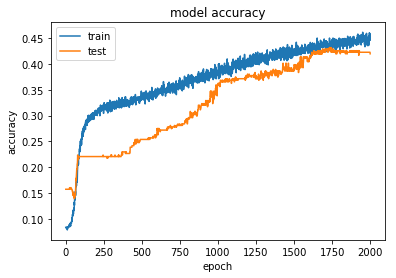

In [119]:
plt.plot(business_model.history['acc'])
plt.plot(business_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [122]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(7, activation='softmax'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
w2v_model = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=3000, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)

Train on 2839 samples, validate on 331 samples
Epoch 1/3000
2839/2839 [==============================] - 1s 428us/step - loss: 1.0403 - acc: 0.0377 - val_loss: 1.9214 - val_acc: 0.3776
Epoch 2/3000
2839/2839 [==============================] - 0s 66us/step - loss: 1.0089 - acc: 0.2325 - val_loss: 1.8246 - val_acc: 0.2175
Epoch 3/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.9594 - acc: 0.2624 - val_loss: 1.6648 - val_acc: 0.2175
Epoch 4/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.9060 - acc: 0.3424 - val_loss: 1.5601 - val_acc: 0.2175
Epoch 5/3000
2839/2839 [==============================] - 0s 66us/step - loss: 0.9090 - acc: 0.3730 - val_loss: 1.5225 - val_acc: 0.2175
Epoch 6/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.8854 - acc: 0.3660 - val_loss: 1.5903 - val_acc: 0.2175
Epoch 7/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.8887 - acc: 0.3593 - val_loss: 1.5650 - val_acc: 

2839/2839 [==============================] - 0s 65us/step - loss: 0.7251 - acc: 0.3198 - val_loss: 1.3564 - val_acc: 0.2054
Epoch 61/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.7152 - acc: 0.3364 - val_loss: 1.3591 - val_acc: 0.2054
Epoch 62/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.7180 - acc: 0.3526 - val_loss: 1.4474 - val_acc: 0.1813
Epoch 63/3000
2839/2839 [==============================] - 0s 89us/step - loss: 0.7291 - acc: 0.3357 - val_loss: 1.3854 - val_acc: 0.2115
Epoch 64/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7061 - acc: 0.3470 - val_loss: 1.3211 - val_acc: 0.3474
Epoch 65/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.7141 - acc: 0.3667 - val_loss: 1.3580 - val_acc: 0.2175
Epoch 66/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.7080 - acc: 0.3536 - val_loss: 1.3927 - val_acc: 0.2175
Epoch 67/3000
2839/2839 [=======================

2839/2839 [==============================] - 0s 79us/step - loss: 0.6195 - acc: 0.4477 - val_loss: 1.2072 - val_acc: 0.4562
Epoch 120/3000
2839/2839 [==============================] - 0s 59us/step - loss: 0.6383 - acc: 0.4847 - val_loss: 1.1578 - val_acc: 0.4562
Epoch 121/3000
2839/2839 [==============================] - ETA: 0s - loss: 0.6376 - acc: 0.450 - 0s 70us/step - loss: 0.6349 - acc: 0.4178 - val_loss: 1.1598 - val_acc: 0.4562
Epoch 122/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.6589 - acc: 0.4188 - val_loss: 1.2854 - val_acc: 0.2568
Epoch 123/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.6468 - acc: 0.3808 - val_loss: 1.2059 - val_acc: 0.4048
Epoch 124/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.6103 - acc: 0.4385 - val_loss: 1.1490 - val_acc: 0.4804
Epoch 125/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.6159 - acc: 0.4632 - val_loss: 1.1792 - val_acc: 0.4411
Epoc

Epoch 178/3000
2839/2839 [==============================] - 0s 59us/step - loss: 0.5879 - acc: 0.4456 - val_loss: 1.1942 - val_acc: 0.5287
Epoch 179/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5677 - acc: 0.4900 - val_loss: 1.1392 - val_acc: 0.5317
Epoch 180/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.5815 - acc: 0.4833 - val_loss: 1.1546 - val_acc: 0.5136
Epoch 181/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.5543 - acc: 0.4868 - val_loss: 1.2465 - val_acc: 0.4804
Epoch 182/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5375 - acc: 0.5114 - val_loss: 1.5998 - val_acc: 0.3051
Epoch 183/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.6481 - acc: 0.4058 - val_loss: 1.2073 - val_acc: 0.5076
Epoch 184/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.5537 - acc: 0.4959 - val_loss: 1.2018 - val_acc: 0.5166
Epoch 185/3000
2839/2839 [=

Epoch 237/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.6141 - acc: 0.5350 - val_loss: 1.2119 - val_acc: 0.4592
Epoch 238/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.4897 - acc: 0.5199 - val_loss: 1.2502 - val_acc: 0.4773
Epoch 239/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.4846 - acc: 0.5199 - val_loss: 1.2442 - val_acc: 0.4713
Epoch 240/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.4929 - acc: 0.5195 - val_loss: 1.3443 - val_acc: 0.4320
Epoch 241/3000
2839/2839 [==============================] - 0s 66us/step - loss: 0.4991 - acc: 0.5167 - val_loss: 1.3302 - val_acc: 0.4199
Epoch 242/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.5154 - acc: 0.4956 - val_loss: 1.2490 - val_acc: 0.4653
Epoch 243/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.4945 - acc: 0.5280 - val_loss: 1.1641 - val_acc: 0.5770
Epoch 244/3000
2839/2839 [=

Epoch 296/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.4405 - acc: 0.5625 - val_loss: 1.5338 - val_acc: 0.4411
Epoch 297/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.5322 - acc: 0.4995 - val_loss: 1.2565 - val_acc: 0.5136
Epoch 298/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.4559 - acc: 0.5428 - val_loss: 1.2486 - val_acc: 0.4894
Epoch 299/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.4209 - acc: 0.5604 - val_loss: 1.3974 - val_acc: 0.3988
Epoch 300/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.4379 - acc: 0.5326 - val_loss: 1.4407 - val_acc: 0.3867
Epoch 301/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.4659 - acc: 0.4991 - val_loss: 1.3270 - val_acc: 0.4773
Epoch 302/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.4330 - acc: 0.5439 - val_loss: 1.2398 - val_acc: 0.5166
Epoch 303/3000
2839/2839 [=

Epoch 355/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4023 - acc: 0.5576 - val_loss: 1.5030 - val_acc: 0.4139
Epoch 356/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.3967 - acc: 0.5544 - val_loss: 1.4625 - val_acc: 0.5227
Epoch 357/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.4501 - acc: 0.5667 - val_loss: 1.2935 - val_acc: 0.5861
Epoch 358/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.4296 - acc: 0.6006 - val_loss: 1.2305 - val_acc: 0.5559
Epoch 359/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.4437 - acc: 0.5932 - val_loss: 1.2908 - val_acc: 0.5408
Epoch 360/3000
2839/2839 [==============================] - 0s 93us/step - loss: 0.3804 - acc: 0.6319 - val_loss: 1.3287 - val_acc: 0.5559
Epoch 361/3000
2839/2839 [==============================] - 0s 95us/step - loss: 0.3715 - acc: 0.6284 - val_loss: 1.3942 - val_acc: 0.5045
Epoch 362/3000
2839/2839 [=

Epoch 414/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.4482 - acc: 0.6242 - val_loss: 1.4085 - val_acc: 0.5317
Epoch 415/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.3501 - acc: 0.6316 - val_loss: 1.4194 - val_acc: 0.5408
Epoch 416/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.3302 - acc: 0.6516 - val_loss: 1.4365 - val_acc: 0.5257
Epoch 417/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.3254 - acc: 0.6576 - val_loss: 1.4922 - val_acc: 0.5015
Epoch 418/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.3267 - acc: 0.6302 - val_loss: 1.4929 - val_acc: 0.5287
Epoch 419/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3527 - acc: 0.6125 - val_loss: 1.6156 - val_acc: 0.4471
Epoch 420/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.3781 - acc: 0.5865 - val_loss: 1.7430 - val_acc: 0.4320
Epoch 421/3000
2839/2839 [=

Epoch 473/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.3015 - acc: 0.6795 - val_loss: 1.5336 - val_acc: 0.5227
Epoch 474/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.3172 - acc: 0.6404 - val_loss: 1.4606 - val_acc: 0.5529
Epoch 475/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3393 - acc: 0.6819 - val_loss: 1.6018 - val_acc: 0.4804
Epoch 476/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.4530 - acc: 0.6076 - val_loss: 1.4744 - val_acc: 0.5347
Epoch 477/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3960 - acc: 0.6654 - val_loss: 1.4956 - val_acc: 0.5136
Epoch 478/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3303 - acc: 0.6464 - val_loss: 1.4722 - val_acc: 0.5529
Epoch 479/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.3088 - acc: 0.6784 - val_loss: 1.4993 - val_acc: 0.5710
Epoch 480/3000
2839/2839 [=

Epoch 532/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3470 - acc: 0.6714 - val_loss: 1.6758 - val_acc: 0.5408
Epoch 533/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.3890 - acc: 0.6471 - val_loss: 1.5089 - val_acc: 0.5921
Epoch 534/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.3174 - acc: 0.6855 - val_loss: 1.6233 - val_acc: 0.5378
Epoch 535/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.3682 - acc: 0.6368 - val_loss: 1.8410 - val_acc: 0.5196
Epoch 536/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.4764 - acc: 0.6157 - val_loss: 1.5246 - val_acc: 0.5076
Epoch 537/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3266 - acc: 0.6273 - val_loss: 1.5278 - val_acc: 0.5106
Epoch 538/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.2920 - acc: 0.6576 - val_loss: 1.5233 - val_acc: 0.5770
Epoch 539/3000
2839/2839 [=

Epoch 591/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.2594 - acc: 0.7253 - val_loss: 1.6967 - val_acc: 0.5408
Epoch 592/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.2858 - acc: 0.7182 - val_loss: 1.7210 - val_acc: 0.5015
Epoch 593/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.3156 - acc: 0.6809 - val_loss: 1.8639 - val_acc: 0.4260
Epoch 594/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.3546 - acc: 0.6076 - val_loss: 1.7222 - val_acc: 0.4955
Epoch 595/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.2857 - acc: 0.6425 - val_loss: 1.7041 - val_acc: 0.5408
Epoch 596/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.2710 - acc: 0.6879 - val_loss: 1.6861 - val_acc: 0.5589
Epoch 597/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.2596 - acc: 0.6981 - val_loss: 1.7341 - val_acc: 0.5861
Epoch 598/3000
2839/2839 [=

Epoch 650/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.2354 - acc: 0.7397 - val_loss: 1.7458 - val_acc: 0.5680
Epoch 651/3000
2839/2839 [==============================] - 0s 100us/step - loss: 0.2357 - acc: 0.7319 - val_loss: 1.8136 - val_acc: 0.5650
Epoch 652/3000
2839/2839 [==============================] - 0s 92us/step - loss: 0.3715 - acc: 0.6802 - val_loss: 1.8973 - val_acc: 0.4562
Epoch 653/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.4386 - acc: 0.6474 - val_loss: 1.7700 - val_acc: 0.4894
Epoch 654/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.3008 - acc: 0.6862 - val_loss: 1.5658 - val_acc: 0.5801
Epoch 655/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2311 - acc: 0.7591 - val_loss: 1.7357 - val_acc: 0.5650
Epoch 656/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.2305 - acc: 0.7446 - val_loss: 1.7357 - val_acc: 0.5529
Epoch 657/3000
2839/2839 [

Epoch 709/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.2359 - acc: 0.7601 - val_loss: 1.7874 - val_acc: 0.5831
Epoch 710/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.2497 - acc: 0.7436 - val_loss: 1.9467 - val_acc: 0.5710
Epoch 711/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.3035 - acc: 0.7143 - val_loss: 1.7880 - val_acc: 0.5529
Epoch 712/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.2256 - acc: 0.7570 - val_loss: 1.8091 - val_acc: 0.6073
Epoch 713/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.2242 - acc: 0.7492 - val_loss: 1.8323 - val_acc: 0.5710
Epoch 714/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2419 - acc: 0.7566 - val_loss: 1.8471 - val_acc: 0.5831
Epoch 715/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.2170 - acc: 0.7517 - val_loss: 1.8548 - val_acc: 0.6073
Epoch 716/3000
2839/2839 [=

Epoch 768/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.2338 - acc: 0.7591 - val_loss: 1.9653 - val_acc: 0.5438
Epoch 769/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.2890 - acc: 0.7323 - val_loss: 1.9596 - val_acc: 0.5076
Epoch 770/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2723 - acc: 0.7393 - val_loss: 1.8499 - val_acc: 0.5589
Epoch 771/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.2202 - acc: 0.7862 - val_loss: 1.8054 - val_acc: 0.5982
Epoch 772/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.2168 - acc: 0.7700 - val_loss: 1.8908 - val_acc: 0.5801
Epoch 773/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.2482 - acc: 0.7626 - val_loss: 2.0410 - val_acc: 0.5740
Epoch 774/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2917 - acc: 0.7295 - val_loss: 1.9363 - val_acc: 0.5045
Epoch 775/3000
2839/2839 [=

Epoch 827/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.2999 - acc: 0.6506 - val_loss: 1.8334 - val_acc: 0.5347
Epoch 828/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.2022 - acc: 0.7520 - val_loss: 1.9315 - val_acc: 0.5710
Epoch 829/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1968 - acc: 0.7869 - val_loss: 1.9773 - val_acc: 0.5529
Epoch 830/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1787 - acc: 0.7844 - val_loss: 1.9063 - val_acc: 0.5861
Epoch 831/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1823 - acc: 0.7901 - val_loss: 1.9686 - val_acc: 0.5831
Epoch 832/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.2113 - acc: 0.7513 - val_loss: 1.9215 - val_acc: 0.5801
Epoch 833/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.2021 - acc: 0.7714 - val_loss: 1.9905 - val_acc: 0.5710
Epoch 834/3000
2839/2839 [=

Epoch 886/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1854 - acc: 0.7954 - val_loss: 1.9899 - val_acc: 0.5680
Epoch 887/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1939 - acc: 0.8045 - val_loss: 2.0496 - val_acc: 0.5891
Epoch 888/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1775 - acc: 0.8200 - val_loss: 2.0020 - val_acc: 0.5650
Epoch 889/3000
2839/2839 [==============================] - 0s 94us/step - loss: 0.1814 - acc: 0.8070 - val_loss: 2.0419 - val_acc: 0.5831
Epoch 890/3000
2839/2839 [==============================] - 0s 98us/step - loss: 0.1781 - acc: 0.8182 - val_loss: 2.0127 - val_acc: 0.6073
Epoch 891/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.1779 - acc: 0.8235 - val_loss: 2.1815 - val_acc: 0.5529
Epoch 892/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.2375 - acc: 0.7587 - val_loss: 1.9865 - val_acc: 0.5770
Epoch 893/3000
2839/2839 [=

Epoch 945/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1738 - acc: 0.8158 - val_loss: 2.1383 - val_acc: 0.5650
Epoch 946/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.1935 - acc: 0.7813 - val_loss: 2.2859 - val_acc: 0.5589
Epoch 947/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.2457 - acc: 0.7598 - val_loss: 2.0124 - val_acc: 0.5347
Epoch 948/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.2313 - acc: 0.7788 - val_loss: 2.1601 - val_acc: 0.5106
Epoch 949/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1946 - acc: 0.8017 - val_loss: 2.0800 - val_acc: 0.5770
Epoch 950/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.1744 - acc: 0.8232 - val_loss: 2.0797 - val_acc: 0.5770
Epoch 951/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.1686 - acc: 0.8214 - val_loss: 2.1836 - val_acc: 0.5740
Epoch 952/3000
2839/2839 [=

Epoch 1004/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1441 - acc: 0.8499 - val_loss: 2.3003 - val_acc: 0.5861
Epoch 1005/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1695 - acc: 0.8221 - val_loss: 2.3214 - val_acc: 0.5710
Epoch 1006/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1941 - acc: 0.8063 - val_loss: 2.2121 - val_acc: 0.5710
Epoch 1007/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2197 - acc: 0.7894 - val_loss: 2.2580 - val_acc: 0.5438
Epoch 1008/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1915 - acc: 0.8151 - val_loss: 2.2387 - val_acc: 0.5589
Epoch 1009/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1733 - acc: 0.8278 - val_loss: 2.2650 - val_acc: 0.5196
Epoch 1010/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1860 - acc: 0.7851 - val_loss: 2.2643 - val_acc: 0.5378
Epoch 1011/3000
2839

2839/2839 [==============================] - 0s 69us/step - loss: 0.1485 - acc: 0.8514 - val_loss: 2.2662 - val_acc: 0.5710
Epoch 1063/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1302 - acc: 0.8651 - val_loss: 2.3298 - val_acc: 0.5952
Epoch 1064/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1435 - acc: 0.8510 - val_loss: 2.4912 - val_acc: 0.5831
Epoch 1065/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.2268 - acc: 0.7862 - val_loss: 2.3404 - val_acc: 0.5045
Epoch 1066/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.2840 - acc: 0.7541 - val_loss: 2.1583 - val_acc: 0.5166
Epoch 1067/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.2033 - acc: 0.8144 - val_loss: 2.1261 - val_acc: 0.5710
Epoch 1068/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1461 - acc: 0.8514 - val_loss: 2.2209 - val_acc: 0.6042
Epoch 1069/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 63us/step - loss: 0.3462 - acc: 0.7115 - val_loss: 2.2546 - val_acc: 0.5468
Epoch 1121/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1649 - acc: 0.8253 - val_loss: 2.2658 - val_acc: 0.5740
Epoch 1122/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1671 - acc: 0.8330 - val_loss: 2.4285 - val_acc: 0.5710
Epoch 1123/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.1418 - acc: 0.8619 - val_loss: 2.3715 - val_acc: 0.5770
Epoch 1124/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.1446 - acc: 0.8461 - val_loss: 2.4087 - val_acc: 0.5801
Epoch 1125/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.1545 - acc: 0.8580 - val_loss: 2.5152 - val_acc: 0.5710
Epoch 1126/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.1322 - acc: 0.8584 - val_loss: 2.5690 - val_acc: 0.5891
Epoch 1127/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 80us/step - loss: 0.1519 - acc: 0.8461 - val_loss: 2.3687 - val_acc: 0.5710
Epoch 1179/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.1496 - acc: 0.8570 - val_loss: 2.5873 - val_acc: 0.5710
Epoch 1180/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1725 - acc: 0.8366 - val_loss: 2.4546 - val_acc: 0.5619
Epoch 1181/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.1353 - acc: 0.8718 - val_loss: 2.4073 - val_acc: 0.5650
Epoch 1182/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.1233 - acc: 0.8774 - val_loss: 2.5203 - val_acc: 0.5982
Epoch 1183/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1762 - acc: 0.8267 - val_loss: 2.3807 - val_acc: 0.5891
Epoch 1184/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.1717 - acc: 0.8355 - val_loss: 2.3337 - val_acc: 0.5982
Epoch 1185/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 82us/step - loss: 0.1479 - acc: 0.8612 - val_loss: 2.4042 - val_acc: 0.5770
Epoch 1237/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1346 - acc: 0.8630 - val_loss: 2.5437 - val_acc: 0.5982
Epoch 1238/3000
2839/2839 [==============================] - 0s 98us/step - loss: 0.1207 - acc: 0.8788 - val_loss: 2.6459 - val_acc: 0.5801
Epoch 1239/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.1849 - acc: 0.8306 - val_loss: 2.4671 - val_acc: 0.5408
Epoch 1240/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1451 - acc: 0.8665 - val_loss: 2.4111 - val_acc: 0.5619
Epoch 1241/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1264 - acc: 0.8739 - val_loss: 2.6057 - val_acc: 0.5770
Epoch 1242/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.1332 - acc: 0.8707 - val_loss: 2.6453 - val_acc: 0.5921
Epoch 1243/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 77us/step - loss: 0.1940 - acc: 0.7640 - val_loss: 2.5366 - val_acc: 0.5710
Epoch 1295/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1499 - acc: 0.8499 - val_loss: 2.5967 - val_acc: 0.5559
Epoch 1296/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.1235 - acc: 0.8707 - val_loss: 2.6750 - val_acc: 0.5680
Epoch 1297/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.1187 - acc: 0.8824 - val_loss: 2.6424 - val_acc: 0.5498
Epoch 1298/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.1236 - acc: 0.8725 - val_loss: 2.6225 - val_acc: 0.6042
Epoch 1299/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.2252 - acc: 0.8443 - val_loss: 2.5683 - val_acc: 0.5468
Epoch 1300/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1757 - acc: 0.8447 - val_loss: 2.5203 - val_acc: 0.5891
Epoch 1301/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 61us/step - loss: 0.1481 - acc: 0.8559 - val_loss: 2.6318 - val_acc: 0.5770
Epoch 1353/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1282 - acc: 0.8848 - val_loss: 2.7775 - val_acc: 0.5740
Epoch 1354/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1343 - acc: 0.8690 - val_loss: 2.6881 - val_acc: 0.5770
Epoch 1355/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.1706 - acc: 0.8591 - val_loss: 2.8364 - val_acc: 0.5710
Epoch 1356/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1415 - acc: 0.8623 - val_loss: 2.7401 - val_acc: 0.5680
Epoch 1357/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.1286 - acc: 0.8813 - val_loss: 2.7202 - val_acc: 0.5801
Epoch 1358/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.1214 - acc: 0.8735 - val_loss: 2.6045 - val_acc: 0.5740
Epoch 1359/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 83us/step - loss: 0.1896 - acc: 0.7946 - val_loss: 2.7523 - val_acc: 0.4894
Epoch 1411/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.2385 - acc: 0.7573 - val_loss: 2.4387 - val_acc: 0.5317
Epoch 1412/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1434 - acc: 0.8528 - val_loss: 2.4676 - val_acc: 0.5287
Epoch 1413/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1079 - acc: 0.8845 - val_loss: 2.6286 - val_acc: 0.5982
Epoch 1414/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0977 - acc: 0.9045 - val_loss: 2.7225 - val_acc: 0.5770
Epoch 1415/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.1031 - acc: 0.9049 - val_loss: 2.7483 - val_acc: 0.5921
Epoch 1416/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.1024 - acc: 0.9077 - val_loss: 2.9407 - val_acc: 0.5498
Epoch 1417/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 61us/step - loss: 0.1310 - acc: 0.8806 - val_loss: 2.6403 - val_acc: 0.5408
Epoch 1469/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.1158 - acc: 0.8626 - val_loss: 2.6929 - val_acc: 0.5710
Epoch 1470/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.1135 - acc: 0.9084 - val_loss: 2.6181 - val_acc: 0.5861
Epoch 1471/3000
2839/2839 [==============================] - 0s 87us/step - loss: 0.1077 - acc: 0.8760 - val_loss: 2.7234 - val_acc: 0.5619
Epoch 1472/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1119 - acc: 0.8771 - val_loss: 2.7787 - val_acc: 0.6073
Epoch 1473/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1420 - acc: 0.8584 - val_loss: 2.6377 - val_acc: 0.5952
Epoch 1474/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.1216 - acc: 0.8647 - val_loss: 2.8000 - val_acc: 0.6073
Epoch 1475/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 66us/step - loss: 0.1402 - acc: 0.8630 - val_loss: 2.5725 - val_acc: 0.5740
Epoch 1527/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.1038 - acc: 0.8929 - val_loss: 2.7613 - val_acc: 0.5861
Epoch 1528/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.0867 - acc: 0.9130 - val_loss: 2.7380 - val_acc: 0.5619
Epoch 1529/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1046 - acc: 0.8838 - val_loss: 2.8759 - val_acc: 0.5740
Epoch 1530/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1245 - acc: 0.8697 - val_loss: 2.7197 - val_acc: 0.5831
Epoch 1531/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.1828 - acc: 0.8323 - val_loss: 2.5722 - val_acc: 0.5861
Epoch 1532/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1454 - acc: 0.8626 - val_loss: 2.6451 - val_acc: 0.5770
Epoch 1533/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 80us/step - loss: 0.1135 - acc: 0.9077 - val_loss: 2.6443 - val_acc: 0.5589
Epoch 1585/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0917 - acc: 0.9063 - val_loss: 2.7030 - val_acc: 0.5710
Epoch 1586/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.0954 - acc: 0.9021 - val_loss: 2.8363 - val_acc: 0.5740
Epoch 1587/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.1002 - acc: 0.9021 - val_loss: 2.7600 - val_acc: 0.5589
Epoch 1588/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1116 - acc: 0.9045 - val_loss: 2.7815 - val_acc: 0.5498
Epoch 1589/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0960 - acc: 0.9088 - val_loss: 2.7831 - val_acc: 0.5831
Epoch 1590/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.0991 - acc: 0.9074 - val_loss: 2.9438 - val_acc: 0.5589
Epoch 1591/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 83us/step - loss: 0.0981 - acc: 0.9148 - val_loss: 3.1013 - val_acc: 0.5831
Epoch 1643/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.1171 - acc: 0.8908 - val_loss: 2.9739 - val_acc: 0.6042
Epoch 1644/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1420 - acc: 0.8809 - val_loss: 2.8365 - val_acc: 0.5680
Epoch 1645/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.1231 - acc: 0.8968 - val_loss: 2.7376 - val_acc: 0.5801
Epoch 1646/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.1226 - acc: 0.8926 - val_loss: 2.7280 - val_acc: 0.5861
Epoch 1647/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1362 - acc: 0.8880 - val_loss: 2.7612 - val_acc: 0.5891
Epoch 1648/3000
2839/2839 [==============================] - 0s 66us/step - loss: 0.1609 - acc: 0.8521 - val_loss: 2.7810 - val_acc: 0.5347
Epoch 1649/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 79us/step - loss: 0.0866 - acc: 0.9229 - val_loss: 2.9236 - val_acc: 0.5559
Epoch 1701/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.1157 - acc: 0.8919 - val_loss: 3.1373 - val_acc: 0.5861
Epoch 1702/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.2146 - acc: 0.8271 - val_loss: 2.9268 - val_acc: 0.5287
Epoch 1703/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.1485 - acc: 0.8630 - val_loss: 2.8410 - val_acc: 0.5680
Epoch 1704/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1107 - acc: 0.9102 - val_loss: 2.9042 - val_acc: 0.5740
Epoch 1705/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.1093 - acc: 0.9137 - val_loss: 2.9708 - val_acc: 0.5740
Epoch 1706/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.0950 - acc: 0.9200 - val_loss: 2.8780 - val_acc: 0.5710
Epoch 1707/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 70us/step - loss: 0.0687 - acc: 0.9334 - val_loss: 3.0651 - val_acc: 0.5891
Epoch 1759/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.0864 - acc: 0.9232 - val_loss: 2.9717 - val_acc: 0.5680
Epoch 1760/3000
2839/2839 [==============================] - 0s 86us/step - loss: 0.0936 - acc: 0.9141 - val_loss: 3.0937 - val_acc: 0.5650
Epoch 1761/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0754 - acc: 0.9278 - val_loss: 2.9010 - val_acc: 0.5347
Epoch 1762/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.1075 - acc: 0.9183 - val_loss: 2.9127 - val_acc: 0.5770
Epoch 1763/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.1792 - acc: 0.8669 - val_loss: 2.9637 - val_acc: 0.4834
Epoch 1764/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.2210 - acc: 0.7830 - val_loss: 2.6710 - val_acc: 0.5347
Epoch 1765/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 72us/step - loss: 0.1084 - acc: 0.8968 - val_loss: 2.8304 - val_acc: 0.5982
Epoch 1817/3000
2839/2839 [==============================] - 0s 101us/step - loss: 0.0861 - acc: 0.9105 - val_loss: 2.9505 - val_acc: 0.5861
Epoch 1818/3000
2839/2839 [==============================] - 0s 86us/step - loss: 0.0952 - acc: 0.9074 - val_loss: 2.9378 - val_acc: 0.5982
Epoch 1819/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1023 - acc: 0.9130 - val_loss: 2.8686 - val_acc: 0.6042
Epoch 1820/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1143 - acc: 0.9081 - val_loss: 3.1390 - val_acc: 0.5257
Epoch 1821/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1005 - acc: 0.9035 - val_loss: 3.1856 - val_acc: 0.5408
Epoch 1822/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1080 - acc: 0.8993 - val_loss: 3.0351 - val_acc: 0.5831
Epoch 1823/3000
2839/2839 [========

2839/2839 [==============================] - 0s 74us/step - loss: 0.1027 - acc: 0.8890 - val_loss: 3.0475 - val_acc: 0.6042
Epoch 1875/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.0878 - acc: 0.9172 - val_loss: 3.1425 - val_acc: 0.5921
Epoch 1876/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0752 - acc: 0.9285 - val_loss: 3.1997 - val_acc: 0.5982
Epoch 1877/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.0941 - acc: 0.9331 - val_loss: 3.2423 - val_acc: 0.5801
Epoch 1878/3000
2839/2839 [==============================] - 0s 86us/step - loss: 0.1001 - acc: 0.9144 - val_loss: 3.4340 - val_acc: 0.5861
Epoch 1879/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1285 - acc: 0.9035 - val_loss: 3.2004 - val_acc: 0.5982
Epoch 1880/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0898 - acc: 0.9190 - val_loss: 3.1530 - val_acc: 0.6073
Epoch 1881/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 68us/step - loss: 0.1231 - acc: 0.9070 - val_loss: 3.0138 - val_acc: 0.5770
Epoch 1933/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.1808 - acc: 0.8609 - val_loss: 2.9455 - val_acc: 0.5770
Epoch 1934/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.1614 - acc: 0.8743 - val_loss: 2.8658 - val_acc: 0.5559
Epoch 1935/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.0979 - acc: 0.8943 - val_loss: 3.0596 - val_acc: 0.5831
Epoch 1936/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0976 - acc: 0.9348 - val_loss: 2.9473 - val_acc: 0.5770
Epoch 1937/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.0833 - acc: 0.9313 - val_loss: 2.9663 - val_acc: 0.5982
Epoch 1938/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0916 - acc: 0.9207 - val_loss: 2.9284 - val_acc: 0.5921
Epoch 1939/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 81us/step - loss: 0.1665 - acc: 0.8753 - val_loss: 3.1067 - val_acc: 0.5710
Epoch 1991/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1320 - acc: 0.9045 - val_loss: 2.8944 - val_acc: 0.5770
Epoch 1992/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.1040 - acc: 0.9218 - val_loss: 3.0589 - val_acc: 0.5740
Epoch 1993/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.0727 - acc: 0.9271 - val_loss: 3.1083 - val_acc: 0.5982
Epoch 1994/3000
2839/2839 [==============================] - 0s 59us/step - loss: 0.0861 - acc: 0.9239 - val_loss: 2.9821 - val_acc: 0.5861
Epoch 1995/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0860 - acc: 0.9296 - val_loss: 3.0937 - val_acc: 0.5770
Epoch 1996/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.0700 - acc: 0.9408 - val_loss: 3.2119 - val_acc: 0.6012
Epoch 1997/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 81us/step - loss: 0.0875 - acc: 0.9324 - val_loss: 3.0480 - val_acc: 0.5740
Epoch 2049/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.0998 - acc: 0.9158 - val_loss: 2.9252 - val_acc: 0.5921
Epoch 2050/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.1133 - acc: 0.9109 - val_loss: 2.9382 - val_acc: 0.5801
Epoch 2051/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.0810 - acc: 0.9317 - val_loss: 3.0984 - val_acc: 0.5770
Epoch 2052/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0719 - acc: 0.9398 - val_loss: 3.2417 - val_acc: 0.5952
Epoch 2053/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.0765 - acc: 0.9380 - val_loss: 3.2530 - val_acc: 0.5831
Epoch 2054/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.0794 - acc: 0.9373 - val_loss: 3.1083 - val_acc: 0.5982
Epoch 2055/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 81us/step - loss: 0.0827 - acc: 0.9236 - val_loss: 3.5418 - val_acc: 0.5589
Epoch 2107/3000
2839/2839 [==============================] - 0s 85us/step - loss: 0.1418 - acc: 0.8901 - val_loss: 3.2558 - val_acc: 0.5408
Epoch 2108/3000
2839/2839 [==============================] - 0s 100us/step - loss: 0.1654 - acc: 0.8926 - val_loss: 3.1710 - val_acc: 0.5619
Epoch 2109/3000
2839/2839 [==============================] - 0s 67us/step - loss: 0.0915 - acc: 0.9348 - val_loss: 3.1247 - val_acc: 0.5740
Epoch 2110/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0780 - acc: 0.9264 - val_loss: 2.9981 - val_acc: 0.5740
Epoch 2111/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0682 - acc: 0.9362 - val_loss: 3.1713 - val_acc: 0.5801
Epoch 2112/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0775 - acc: 0.9380 - val_loss: 3.1913 - val_acc: 0.5952
Epoch 2113/3000
2839/2839 [========

2839/2839 [==============================] - 0s 71us/step - loss: 0.0824 - acc: 0.9306 - val_loss: 3.0512 - val_acc: 0.5498
Epoch 2165/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1032 - acc: 0.9049 - val_loss: 3.0038 - val_acc: 0.5619
Epoch 2166/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0782 - acc: 0.9183 - val_loss: 3.0220 - val_acc: 0.5136
Epoch 2167/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0983 - acc: 0.8982 - val_loss: 3.0596 - val_acc: 0.5438
Epoch 2168/3000
2839/2839 [==============================] - 0s 60us/step - loss: 0.1095 - acc: 0.9024 - val_loss: 3.0382 - val_acc: 0.5680
Epoch 2169/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0940 - acc: 0.9021 - val_loss: 3.1027 - val_acc: 0.5710
Epoch 2170/3000
2839/2839 [==============================] - 0s 61us/step - loss: 0.0687 - acc: 0.9373 - val_loss: 3.1670 - val_acc: 0.5710
Epoch 2171/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 78us/step - loss: 0.0806 - acc: 0.9384 - val_loss: 3.2444 - val_acc: 0.5831
Epoch 2223/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0658 - acc: 0.9433 - val_loss: 3.1967 - val_acc: 0.5831
Epoch 2224/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0749 - acc: 0.9408 - val_loss: 3.4763 - val_acc: 0.5740
Epoch 2225/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0799 - acc: 0.9334 - val_loss: 3.3505 - val_acc: 0.5952
Epoch 2226/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.0995 - acc: 0.9355 - val_loss: 3.2282 - val_acc: 0.5801
Epoch 2227/3000
2839/2839 [==============================] - 0s 73us/step - loss: 0.0791 - acc: 0.9296 - val_loss: 3.2887 - val_acc: 0.5740
Epoch 2228/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0719 - acc: 0.9408 - val_loss: 3.1887 - val_acc: 0.5650
Epoch 2229/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 67us/step - loss: 0.0566 - acc: 0.9468 - val_loss: 3.5338 - val_acc: 0.5408
Epoch 2281/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0981 - acc: 0.9155 - val_loss: 3.3799 - val_acc: 0.5257
Epoch 2282/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.1192 - acc: 0.8651 - val_loss: 3.1764 - val_acc: 0.5680
Epoch 2283/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.0702 - acc: 0.9095 - val_loss: 3.3634 - val_acc: 0.5861
Epoch 2284/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.0667 - acc: 0.9482 - val_loss: 3.4040 - val_acc: 0.5861
Epoch 2285/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.0737 - acc: 0.9387 - val_loss: 3.4568 - val_acc: 0.5831
Epoch 2286/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0640 - acc: 0.9454 - val_loss: 3.6253 - val_acc: 0.5982
Epoch 2287/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 81us/step - loss: 0.0851 - acc: 0.9250 - val_loss: 3.3293 - val_acc: 0.5861
Epoch 2339/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.0644 - acc: 0.9433 - val_loss: 3.2757 - val_acc: 0.6042
Epoch 2340/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.0523 - acc: 0.9532 - val_loss: 3.4085 - val_acc: 0.5831
Epoch 2341/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0523 - acc: 0.9570 - val_loss: 3.5061 - val_acc: 0.5982
Epoch 2342/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0898 - acc: 0.9334 - val_loss: 3.5193 - val_acc: 0.6042
Epoch 2343/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.1277 - acc: 0.9010 - val_loss: 3.1363 - val_acc: 0.5952
Epoch 2344/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.1515 - acc: 0.8986 - val_loss: 2.9351 - val_acc: 0.5710
Epoch 2345/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 80us/step - loss: 0.1246 - acc: 0.9088 - val_loss: 3.1792 - val_acc: 0.5740
Epoch 2397/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0823 - acc: 0.9426 - val_loss: 3.4334 - val_acc: 0.5710
Epoch 2398/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0759 - acc: 0.9398 - val_loss: 3.3307 - val_acc: 0.5801
Epoch 2399/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.0716 - acc: 0.9373 - val_loss: 3.4016 - val_acc: 0.5770
Epoch 2400/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0654 - acc: 0.9458 - val_loss: 3.3293 - val_acc: 0.5831
Epoch 2401/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0696 - acc: 0.9362 - val_loss: 3.5559 - val_acc: 0.5861
Epoch 2402/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0814 - acc: 0.9348 - val_loss: 3.5074 - val_acc: 0.5589
Epoch 2403/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 84us/step - loss: 0.0693 - acc: 0.9451 - val_loss: 3.4858 - val_acc: 0.5861
Epoch 2455/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.0822 - acc: 0.9306 - val_loss: 3.4688 - val_acc: 0.5740
Epoch 2456/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.0845 - acc: 0.9369 - val_loss: 3.5805 - val_acc: 0.5680
Epoch 2457/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0981 - acc: 0.9278 - val_loss: 3.4340 - val_acc: 0.5650
Epoch 2458/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0841 - acc: 0.9458 - val_loss: 3.4069 - val_acc: 0.5801
Epoch 2459/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0717 - acc: 0.9507 - val_loss: 3.2425 - val_acc: 0.5650
Epoch 2460/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0741 - acc: 0.9373 - val_loss: 3.7256 - val_acc: 0.5801
Epoch 2461/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 74us/step - loss: 0.0745 - acc: 0.9496 - val_loss: 3.4160 - val_acc: 0.6042
Epoch 2513/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0594 - acc: 0.9514 - val_loss: 3.2765 - val_acc: 0.5861
Epoch 2514/3000
2839/2839 [==============================] - 0s 80us/step - loss: 0.0740 - acc: 0.9355 - val_loss: 3.2328 - val_acc: 0.5861
Epoch 2515/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.1055 - acc: 0.9345 - val_loss: 3.5758 - val_acc: 0.5770
Epoch 2516/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.2049 - acc: 0.8718 - val_loss: 3.1689 - val_acc: 0.5498
Epoch 2517/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.1295 - acc: 0.9176 - val_loss: 3.1548 - val_acc: 0.5468
Epoch 2518/3000
2839/2839 [==============================] - 0s 66us/step - loss: 0.0768 - acc: 0.9292 - val_loss: 3.0982 - val_acc: 0.5831
Epoch 2519/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 78us/step - loss: 0.2574 - acc: 0.8718 - val_loss: 3.1294 - val_acc: 0.5529
Epoch 2571/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0885 - acc: 0.9179 - val_loss: 3.0859 - val_acc: 0.5831
Epoch 2572/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.0614 - acc: 0.9489 - val_loss: 3.2488 - val_acc: 0.6012
Epoch 2573/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.0624 - acc: 0.9458 - val_loss: 3.0863 - val_acc: 0.5770
Epoch 2574/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0624 - acc: 0.9468 - val_loss: 3.1525 - val_acc: 0.5770
Epoch 2575/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0647 - acc: 0.9500 - val_loss: 3.2081 - val_acc: 0.5921
Epoch 2576/3000
2839/2839 [==============================] - 0s 70us/step - loss: 0.0543 - acc: 0.9577 - val_loss: 3.2736 - val_acc: 0.6103
Epoch 2577/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 78us/step - loss: 0.0683 - acc: 0.9429 - val_loss: 3.3272 - val_acc: 0.5831
Epoch 2629/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.0944 - acc: 0.9377 - val_loss: 3.2940 - val_acc: 0.5952
Epoch 2630/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0565 - acc: 0.9507 - val_loss: 3.3998 - val_acc: 0.5770
Epoch 2631/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.0581 - acc: 0.9436 - val_loss: 3.5471 - val_acc: 0.5559
Epoch 2632/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.0739 - acc: 0.9447 - val_loss: 3.3489 - val_acc: 0.5831
Epoch 2633/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.0837 - acc: 0.9422 - val_loss: 3.4072 - val_acc: 0.5831
Epoch 2634/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.0595 - acc: 0.9503 - val_loss: 3.3455 - val_acc: 0.5982
Epoch 2635/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 81us/step - loss: 0.0487 - acc: 0.9574 - val_loss: 3.8013 - val_acc: 0.5891
Epoch 2687/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0962 - acc: 0.9186 - val_loss: 3.6331 - val_acc: 0.5710
Epoch 2688/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.0945 - acc: 0.9317 - val_loss: 3.4863 - val_acc: 0.5650
Epoch 2689/3000
2839/2839 [==============================] - 0s 75us/step - loss: 0.0685 - acc: 0.9429 - val_loss: 3.5976 - val_acc: 0.5650
Epoch 2690/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0649 - acc: 0.9539 - val_loss: 3.5787 - val_acc: 0.5861
Epoch 2691/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0693 - acc: 0.9465 - val_loss: 3.5300 - val_acc: 0.5650
Epoch 2692/3000
2839/2839 [==============================] - 0s 83us/step - loss: 0.0664 - acc: 0.9482 - val_loss: 3.5152 - val_acc: 0.5740
Epoch 2693/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 77us/step - loss: 0.0811 - acc: 0.9285 - val_loss: 3.4343 - val_acc: 0.5619
Epoch 2745/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0632 - acc: 0.9408 - val_loss: 3.3713 - val_acc: 0.5861
Epoch 2746/3000
2839/2839 [==============================] - 0s 84us/step - loss: 0.0772 - acc: 0.9524 - val_loss: 3.3501 - val_acc: 0.5831
Epoch 2747/3000
2839/2839 [==============================] - 0s 76us/step - loss: 0.0559 - acc: 0.9563 - val_loss: 3.4682 - val_acc: 0.5861
Epoch 2748/3000
2839/2839 [==============================] - 0s 62us/step - loss: 0.0510 - acc: 0.9556 - val_loss: 3.5783 - val_acc: 0.6073
Epoch 2749/3000
2839/2839 [==============================] - 0s 71us/step - loss: 0.0767 - acc: 0.9482 - val_loss: 3.4178 - val_acc: 0.5952
Epoch 2750/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.0693 - acc: 0.9556 - val_loss: 3.4913 - val_acc: 0.5831
Epoch 2751/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 83us/step - loss: 0.0580 - acc: 0.9521 - val_loss: 3.4036 - val_acc: 0.5982
Epoch 2803/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.0503 - acc: 0.9567 - val_loss: 3.4681 - val_acc: 0.5952
Epoch 2804/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.0743 - acc: 0.9458 - val_loss: 3.3534 - val_acc: 0.5982
Epoch 2805/3000
2839/2839 [==============================] - 0s 68us/step - loss: 0.0722 - acc: 0.9380 - val_loss: 3.4013 - val_acc: 0.5831
Epoch 2806/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0665 - acc: 0.9362 - val_loss: 3.4376 - val_acc: 0.6012
Epoch 2807/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0490 - acc: 0.9517 - val_loss: 3.4149 - val_acc: 0.5921
Epoch 2808/3000
2839/2839 [==============================] - 0s 85us/step - loss: 0.0560 - acc: 0.9458 - val_loss: 3.5032 - val_acc: 0.5921
Epoch 2809/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 88us/step - loss: 0.0513 - acc: 0.9556 - val_loss: 3.7068 - val_acc: 0.5529
Epoch 2861/3000
2839/2839 [==============================] - 0s 79us/step - loss: 0.0773 - acc: 0.9331 - val_loss: 3.5483 - val_acc: 0.6012
Epoch 2862/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0864 - acc: 0.9401 - val_loss: 3.3627 - val_acc: 0.5982
Epoch 2863/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.0628 - acc: 0.9584 - val_loss: 3.5852 - val_acc: 0.5710
Epoch 2864/3000
2839/2839 [==============================] - 0s 77us/step - loss: 0.0551 - acc: 0.9591 - val_loss: 3.3720 - val_acc: 0.5831
Epoch 2865/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0466 - acc: 0.9532 - val_loss: 3.5608 - val_acc: 0.5952
Epoch 2866/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0437 - acc: 0.9679 - val_loss: 3.6176 - val_acc: 0.5801
Epoch 2867/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 66us/step - loss: 0.0691 - acc: 0.9405 - val_loss: 3.5590 - val_acc: 0.5982
Epoch 2919/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0907 - acc: 0.9429 - val_loss: 3.3452 - val_acc: 0.6042
Epoch 2920/3000
2839/2839 [==============================] - 0s 65us/step - loss: 0.0595 - acc: 0.9556 - val_loss: 3.5515 - val_acc: 0.5921
Epoch 2921/3000
2839/2839 [==============================] - 0s 72us/step - loss: 0.0590 - acc: 0.9517 - val_loss: 3.4375 - val_acc: 0.6042
Epoch 2922/3000
2839/2839 [==============================] - 0s 82us/step - loss: 0.0551 - acc: 0.9489 - val_loss: 3.5497 - val_acc: 0.6042
Epoch 2923/3000
2839/2839 [==============================] - 0s 74us/step - loss: 0.0742 - acc: 0.9539 - val_loss: 3.5690 - val_acc: 0.6254
Epoch 2924/3000
2839/2839 [==============================] - 0s 78us/step - loss: 0.1061 - acc: 0.9472 - val_loss: 3.2963 - val_acc: 0.5921
Epoch 2925/3000
2839/2839 [=========

2839/2839 [==============================] - 0s 76us/step - loss: 0.0943 - acc: 0.9581 - val_loss: 3.4668 - val_acc: 0.5861
Epoch 2977/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0738 - acc: 0.9532 - val_loss: 3.5458 - val_acc: 0.5680
Epoch 2978/3000
2839/2839 [==============================] - 0s 69us/step - loss: 0.0465 - acc: 0.9595 - val_loss: 3.6482 - val_acc: 0.5831
Epoch 2979/3000
2839/2839 [==============================] - 0s 81us/step - loss: 0.0675 - acc: 0.9620 - val_loss: 3.5800 - val_acc: 0.5770
Epoch 2980/3000
2839/2839 [==============================] - 0s 63us/step - loss: 0.0837 - acc: 0.9500 - val_loss: 3.6587 - val_acc: 0.5710
Epoch 2981/3000
2839/2839 [==============================] - 0s 64us/step - loss: 0.0566 - acc: 0.9595 - val_loss: 3.6771 - val_acc: 0.5861
Epoch 2982/3000
2839/2839 [==============================] - 0s 90us/step - loss: 0.0854 - acc: 0.9546 - val_loss: 3.8190 - val_acc: 0.5891
Epoch 2983/3000
2839/2839 [=========

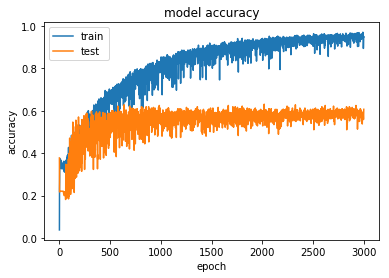

In [124]:
plt.plot(w2v_model.history['acc'])
plt.plot(w2v_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()